In [42]:
from fairseq import checkpoint_utils, options, tasks
from fairseq.data.audio.word_aligned_audio_dataset import zeropad_to_len
import os
import torch
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tslearn import metrics

In [43]:
torch.cuda.is_available()

True

In [44]:
# directories

# speech reps data aligned at word level
DATA = "/home/s1785140/data/ljspeech_hubert_reps/hubert-base/layer-6/word_level_without_padding_idx_offset/"

CHECKPOINT_DIR = "/home/s1785140/fairseq/checkpoints/"

In [45]:
# list of models that we evaluate
MODELS = """
ALL_hubert_transformer_run4_8layers_2heads_2048ffdim_0.1dropout_1.0margin_wPositional
"""
MODELS = MODELS.strip().split('\n')
MODELS

['ALL_hubert_transformer_run4_8layers_2heads_2048ffdim_0.1dropout_1.0margin_wPositional']

In [46]:
# list of checkpoints to evaluate (-1 for last)
CHECKPOINTS = [-1]

In [47]:
# wordtypes to plot
EXAMPLES_PER_WORDTYPE_TO_PLOT = 5
MAX_WORDTYPES_PER_SPLIT = 0
TRAIN_WORDTYPES = """
"""
SEEN_WORDTYPES = """
forms,lead
"""
UNSEEN_WORDTYPES = """
hospital,bread
"""
# SEEN_WORDTYPES = """
# forms,lead,lower,we,determine,expert,especially,board,difficult,visit,energy,down,agencies,drove,complete,able,safety,printed,sixty,sufficient,hill,representatives,cells,inspectors,government,trade,effect,gun,fritz,jefferson,southeast,door,near,employment,time,line,advance,worst,planned,treatment,frequently,improvement,assistant,wanted,fresh,class,rest,knew,firing,tried
# """
# UNSEEN_WORDTYPES = """
# hospital,bread,manner,washington,interest,strange,too,newspaper,intended,visits,true,fauntleroy,babylon,see,through,position,twelve,strong,attack,set,robbery,quote,experience,themselves,including,right,united,forgery,result,inside,inquiry,condition,lines,front,could,escape,enter,permitted,then,directed,regards,paid,wakefield,recognized,held,afterwards,investigation,windows,speak,human
# """

TRAIN_WORDTYPES = TRAIN_WORDTYPES.strip().split(',')
SEEN_WORDTYPES = SEEN_WORDTYPES.strip().split(',')
UNSEEN_WORDTYPES = UNSEEN_WORDTYPES.strip().split(',')
if MAX_WORDTYPES_PER_SPLIT:
    TRAIN_WORDTYPES = TRAIN_WORDTYPES[:MAX_WORDTYPES_PER_SPLIT]
    SEEN_WORDTYPES = SEEN_WORDTYPES[:MAX_WORDTYPES_PER_SPLIT]
    UNSEEN_WORDTYPES = UNSEEN_WORDTYPES[:MAX_WORDTYPES_PER_SPLIT]

WORDTYPES_LIST = [
    # (TRAIN_WORDTYPES, 'train'), # TODO implement this
    (SEEN_WORDTYPES, 'seen'),
    (UNSEEN_WORDTYPES, 'unseen')
]
print(WORDTYPES_LIST)

[(['forms', 'lead'], 'seen'), (['hospital', 'bread'], 'unseen')]


In [48]:
def get_len(filename):
    """get len of wordtype from the filename"""
    return int(filename.rstrip('.pt').split('len')[-1])

get_len("/home/s1785140/data/ljspeech_hubert_reps/hubert-base/layer-6/word_level_without_padding_idx_offset/the/the__LJ018-0086__occ1__len4.pt")

4

In [174]:
def get_inputs_outputs_for_wordtype(
    data, 
    model, 
    wordtype, 
    N, # total number of examples to pass through model
    speechrep_type="hubert"
):
    """
    modified to work with hubert codes, and with seq2seq lexicon learner model
    """
    examples = sorted(os.listdir(os.path.join(data, wordtype)))
    # print("examples in wordtype dir", data, wordtype, examples)
    speechreps = []
    lengths = []
    for e in examples[:N]:
        e_path = os.path.join(data, wordtype, e) 
        # print("debug e_path", e_path)
        speechreps.append(torch.load(e_path).int())
        lengths.append(get_len(e))
    # print(speechreps)
    # print(lengths)
    # hid_dim = speechreps[0].size(1)
    max_len = max(lengths)
    # batch = torch.zeros(N, max_len, hid_dim)
    padded_speechreps = [zeropad_to_len(sr, max_len)[0] for sr in speechreps]
    src_tokens = torch.stack(padded_speechreps)
    src_lengths = torch.Tensor(lengths)
    tgt_tokens = torch.ones(src_lengths.size(0), len(wordtype)).int()
    tgt_lengths = torch.Tensor(src_lengths.size(0) * [len(wordtype)])
    # print(src_tokens.size())
    # print(src_lengths.size())
    # Pass data through model
    y = model(src_tokens, tgt_tokens, tgt_lengths)['continuous_out']
    y = y.detach().numpy()
    
    x = []
    for sr in speechreps:
        src = model.embed_src_tokens(sr).detach().numpy()
        x.append(src)
    
    out_dict = {
        "x": x, 
        "y": y,
        "src_lengths": src_lengths,
        "tgt_lengths": tgt_lengths,
    }
    
    return out_dict

In [50]:
# setup args and fairseq task
parser = options.get_generation_parser(default_task='learn_lexicon_discrete_inputs')
# parser.add_argument("--max_wordtypes_per_split", default=None, type=int)

# method of parsing input args not from command line @ https://github.com/pytorch/fairseq/issues/2648
input_args=[ DATA,
            '--path', CHECKPOINT_DIR,
            # '--source-lang',"text",'--target-lang',"summary", '--beam', '5', '--min-len', '3', '--nbest', '1',
           ]
args = options.parse_args_and_arch(parser, input_args)
task = tasks.setup_task(args)

2021/10/14 16:11:47	INFO	fairseq.tasks.learn_lexicon_discrete_inputs	Source dictionary: PAD,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
2021/10/14 16:11:47	INFO	fairseq.tasks.learn_lexicon_discrete_inputs	Source dictionary: 101 types


In [51]:
def load_model(model, checkpoint_num=None):
    if checkpoint_num is not None:
        raise NotImplementedError
    else:
        chkpt = 'checkpoint_best.pt'
    models, _model_args = checkpoint_utils.load_model_ensemble([os.path.join(args.path, model, chkpt)], task=task)
    return models[0]

#load just a single model for fast testing 
checkpoint_num = None
model = load_model(MODELS[0], checkpoint_num)
model.eval() # make sure model is in eval mode for things like dropout

/home/s1785140/miniconda3/envs/fairseq/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MiniBatchKMeans from version 0.24.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


LexiconLearnerSeq2Seq(
  (embed_src_tokens): Embedding(101, 768, padding_idx=0)
  (embed_tgt_tokens): Embedding(2, 768, padding_idx=0)
  (embed_enc_positions): SinusoidalPositionalEmbedding()
  (embed_dec_positions): SinusoidalPositionalEmbedding()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
  

# Plot softdtw alignments of input speech representations and model outputs

WORDTYPE forms
*** ALIGNMENTS FOR INPUT SPEECH REPS ***


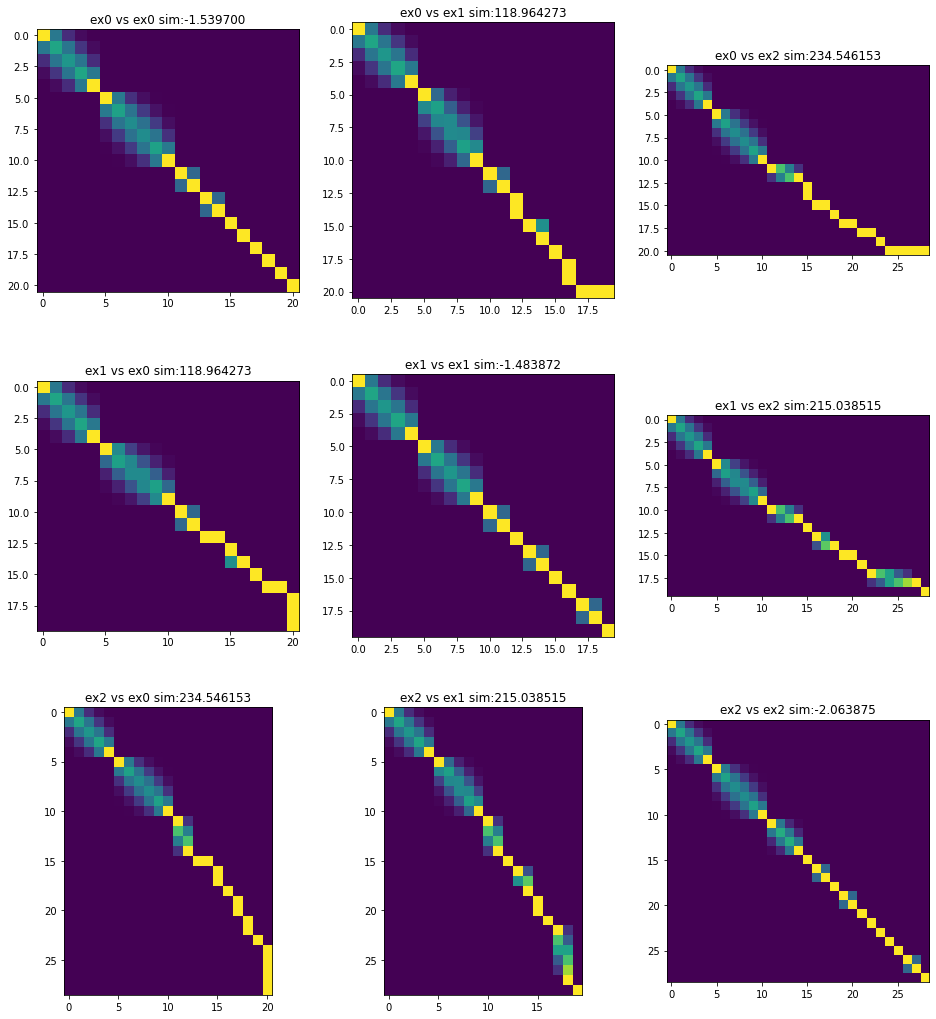

*** ALIGNMENTS FOR MODEL OUTPUTS ***


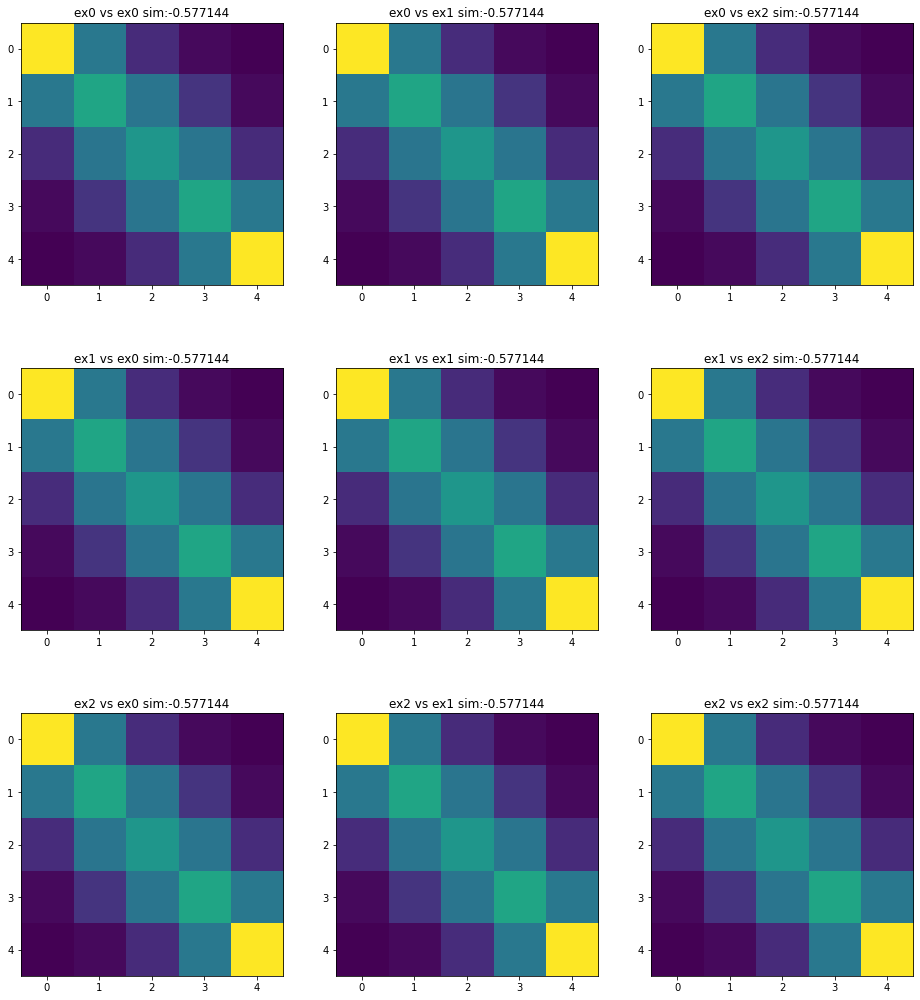

WORDTYPE lead
*** ALIGNMENTS FOR INPUT SPEECH REPS ***


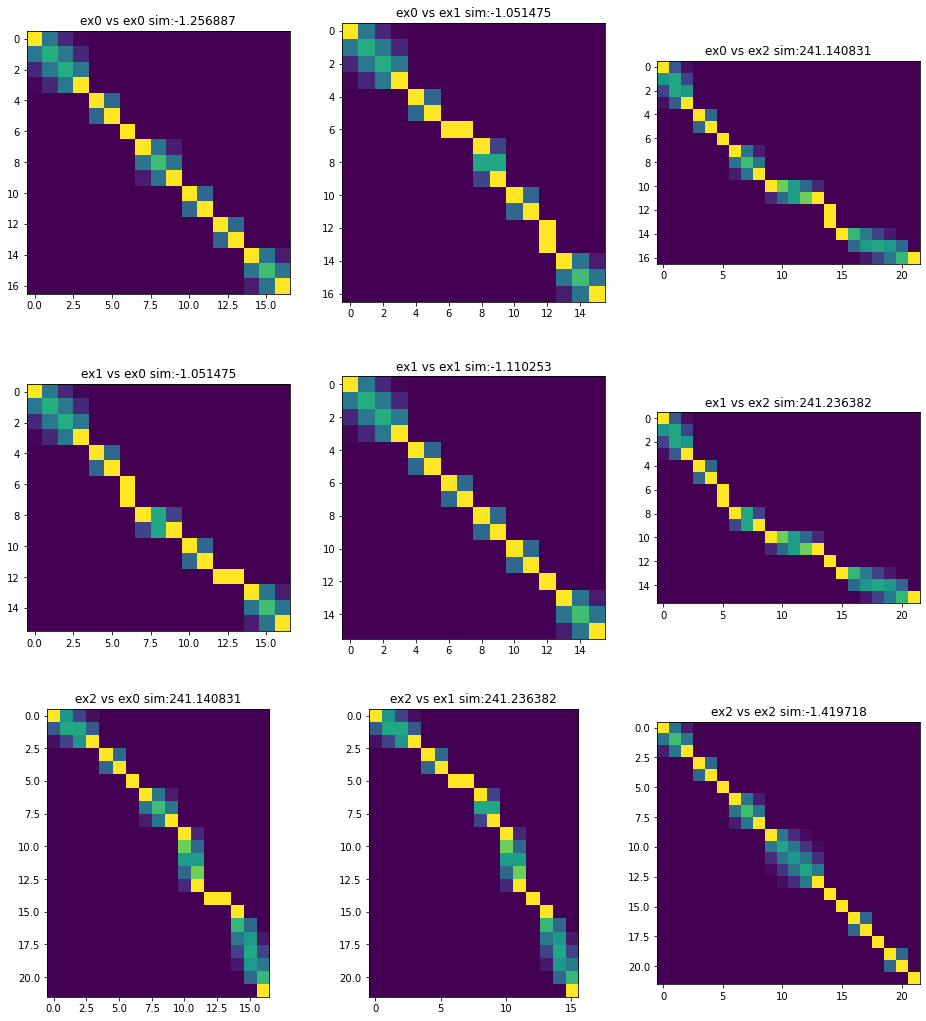

*** ALIGNMENTS FOR MODEL OUTPUTS ***


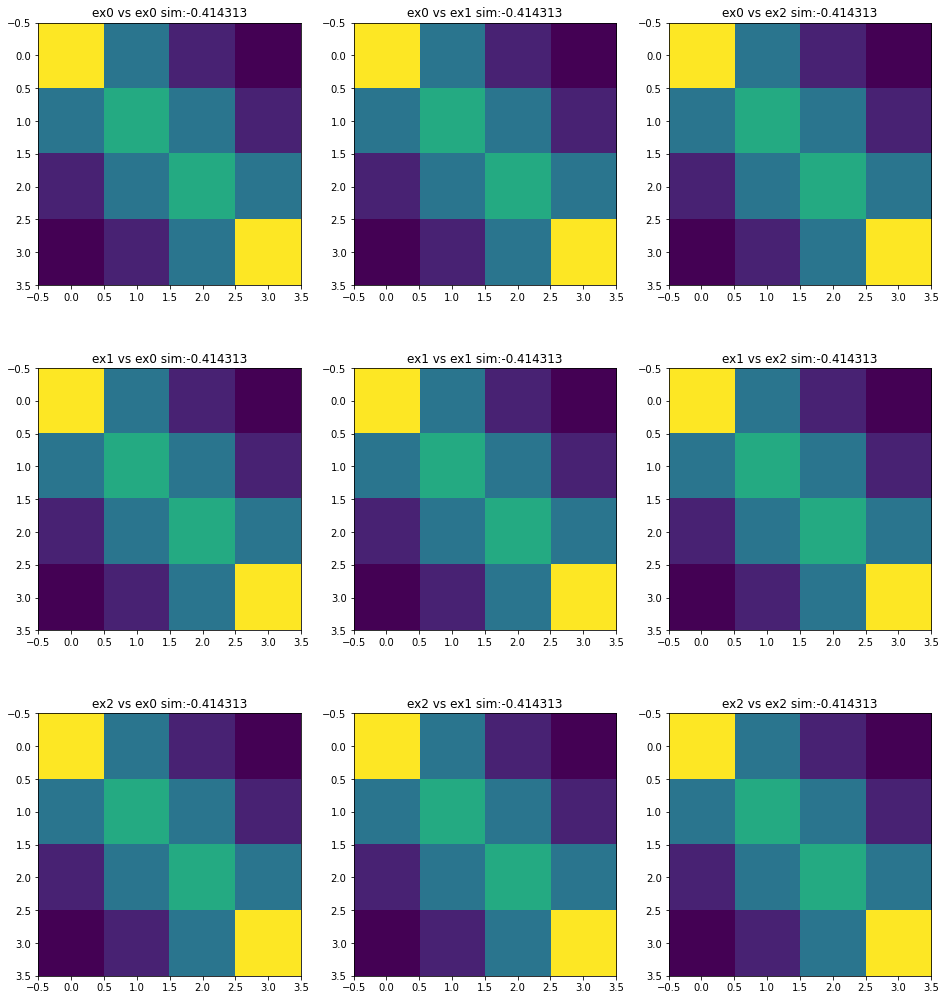

WORDTYPE hospital
*** ALIGNMENTS FOR INPUT SPEECH REPS ***


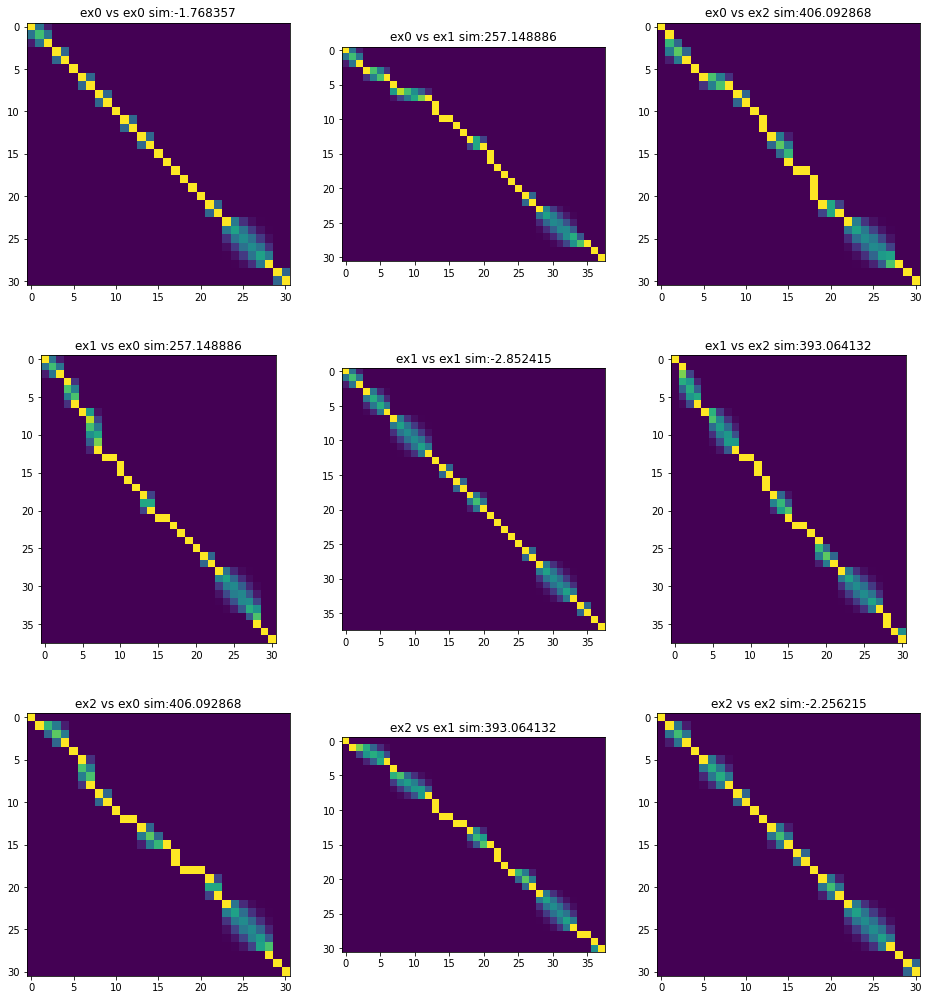

*** ALIGNMENTS FOR MODEL OUTPUTS ***


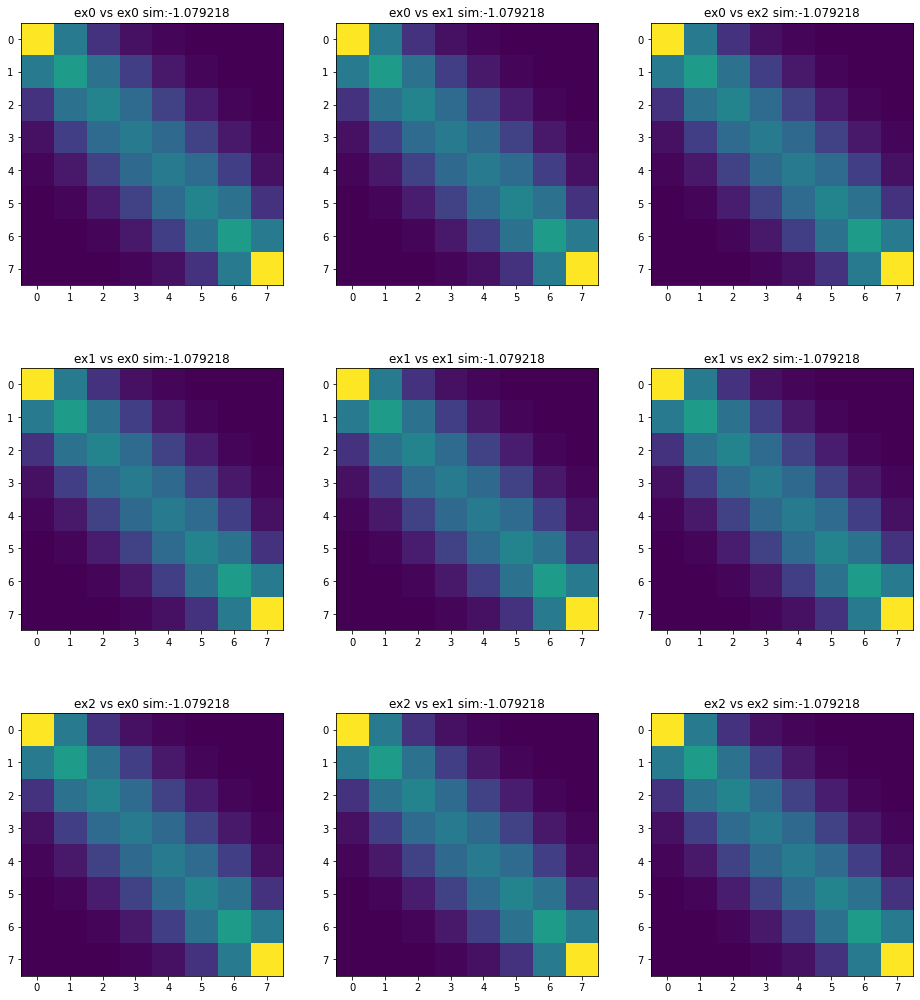

WORDTYPE bread
*** ALIGNMENTS FOR INPUT SPEECH REPS ***


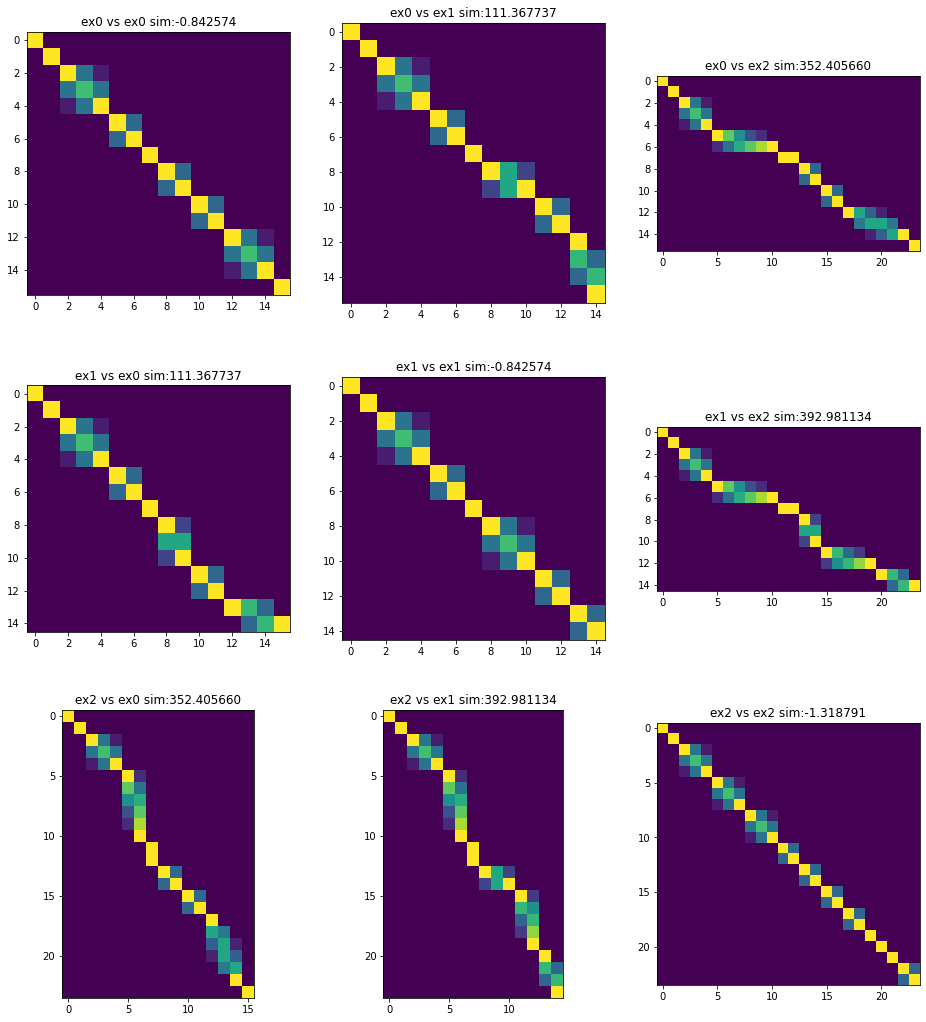

*** ALIGNMENTS FOR MODEL OUTPUTS ***


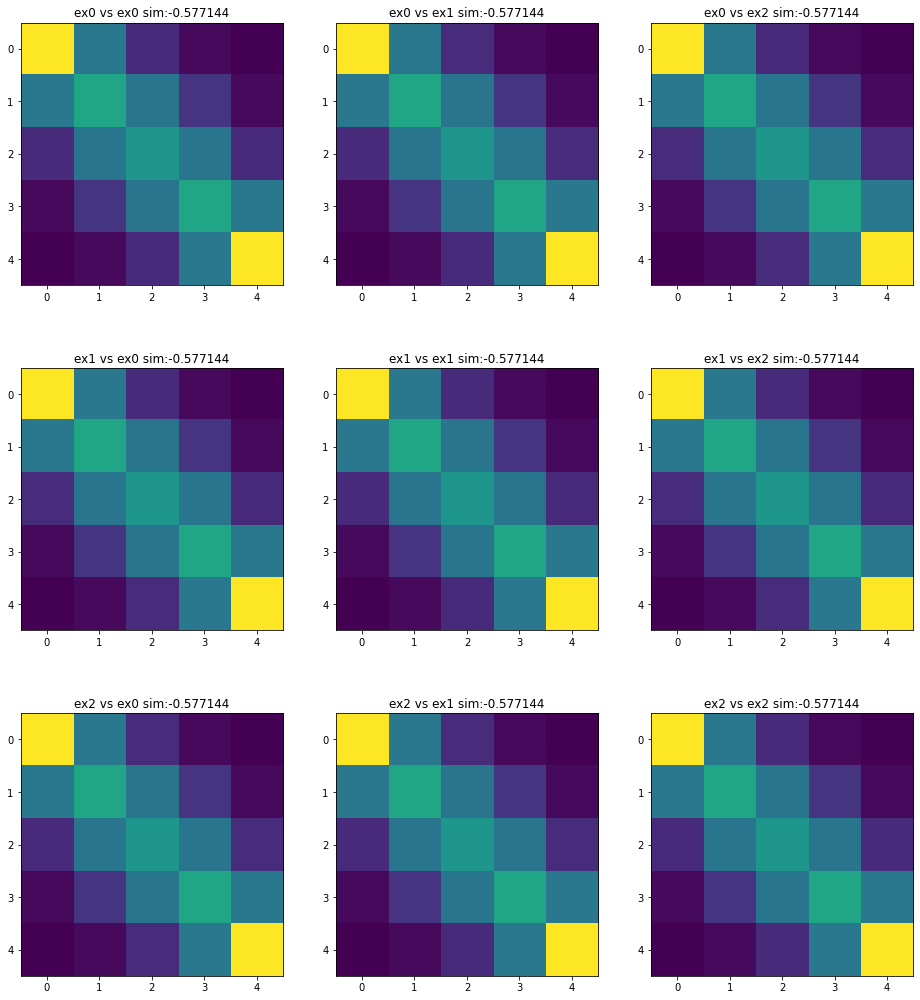

In [52]:
def get_pairs(out):
    """
    get pairs of examples from a batch of examples
    
    out should be outputs from transformer lexicon learner model
    shape: (batch, seq_len, dim)
    
    returns:
        paired_wordexample_indices: list of tuples representing the index of the examples in each pair
            i.e. [(0,0), (0,1), (1,0), (1,1)]
        
        paired_outputs: list of tuples of outputs associated with the paired examples according to paired_wordexample_indices
            i.e. [(ex0out,ex0out), (ex0out,ex1out), (ex1out,ex0out), (ex1out,ex1out)]
    """
    # get paired indices
    paired_wordexample_indices = []
    num_samples = len(out) # should be equivalent to out.shape[0]
    for i in range(num_samples):
        for j in range(num_samples):
            paired_wordexample_indices.append((i,j))
    
    # get paired outputs
    paired_outputs = []
    for i, j in paired_wordexample_indices:
        paired_outputs.append((out[i], out[j]))
    
    return paired_wordexample_indices, paired_outputs

def get_softdtw_alignments(paired_tensors, gamma=0.1):
    alignments = []
    sims = []
    for x, y in paired_tensors:
        align, sim = metrics.soft_dtw_alignment(x, y, gamma=gamma)
        # print(out_i, out_j) 
        # print(align.shape, sim, align)
        alignments.append(align)
        sims.append(sim)
    return alignments, sims
        
    
def plot_softdtw(wordtype, indices, alignment, sim):
    """
    indices is the indices of the examples for a particular wordtype
    
    alignment is the softdtw alignment to plot
    
    sim is the softdtw loss for the particular alignment
    """
    i, j = indices
    plt.imshow(alignment, cmap='viridis')
    plt.title(f"{wordtype} ex{i} vs ex{j} sim:{sim}")
    plt.colorbar()
    plt.show()
    
def plot_grid(wordtype, paired_indices, softdtw_alignments, sims):
    """
    indices is the indices of the examples for a particular wordtype
    
    alignment is the softdtw alignment to plot
    
    sim is the softdtw loss for the particular alignment
    """
    # get size of grid
    grid_side_size = int(len(paired_indices) ** 0.5)
    assert grid_side_size ** 2 == len(paired_indices)
    
    plt.figure(figsize = (16,18))
    
    for k in range(0, len(paired_indices)):
        plt.subplot(grid_side_size, grid_side_size, k+1)
        # plt.text(0.5, 0.5, str((2, 3, i)),
        #      fontsize=18, ha='center')
    
        i, j = paired_indices[k]
        plt.imshow(softdtw_alignments[k], cmap='viridis')
        plt.title(f"ex{i} vs ex{j} sim:{sims[k]:1f}")
        # plt.colorbar()
        # plt.show()
    # plt.colorbar()
    plt.show()

gamma = 0.1 # 0 is equiv to hard alignment

# get outputs for each example of each wordtype in list
for wordtypes, split in WORDTYPES_LIST:
    for w in wordtypes:
        print("WORDTYPE", w)

        out_dict = get_inputs_outputs_for_wordtype(args.data, model, w, N=3) 
        
        x, y = out_dict["x"], out_dict["y"]

        # plot softdtw alignments between speech reps of pairs of examples of each wordtype
        print("*** ALIGNMENTS FOR INPUT SPEECH REPS ***")
        paired_wordexample_indices, paired_tensors = get_pairs(x)
        softdtw_alignments, sims = get_softdtw_alignments(paired_tensors, gamma=gamma) # TODO try 0, 0.1 and 1.0

        # for idxs, align, sim in zip(paired_wordexample_indices, softdtw_alignments, sims):
        #     plot_softdtw(w, idxs, align, sim)
        
        plot_grid(w, paired_wordexample_indices, softdtw_alignments, sims)

        # plot softdtw alignments between outputs of pairs of examples of each wordtype
        print("*** ALIGNMENTS FOR MODEL OUTPUTS ***")
        paired_wordexample_indices, paired_tensors = get_pairs(y)
        softdtw_alignments, sims = get_softdtw_alignments(paired_tensors, gamma=gamma)

#         for idxs, align, sim in zip(paired_wordexample_indices, softdtw_alignments, sims):
#             plot_softdtw(w, idxs, align, sim)

        plot_grid(w, paired_wordexample_indices, softdtw_alignments, sims)

In [53]:
for m in MODELS:
    pass 
    # model = load_model(m, checkpoint_num)

# Plot attention alignments between encoder and decoder transformers of your proposed model

In [139]:
# load single model checkpoint
# print(model)

In [55]:
# define a forward hook manager to extract representations from the layers
from torchdistill.core.forward_hook import ForwardHookManager
device = torch.device('cuda')
forward_hook_manager = ForwardHookManager(device)
# add hooks
forward_hook_manager.add_hook(model, 'embed_src_tokens', requires_input=True, requires_output=True)
forward_hook_manager.add_hook(model, 'embed_tgt_tokens', requires_input=True, requires_output=True)
forward_hook_manager.add_hook(model, 'transformer.decoder.layers.0.multihead_attn', requires_input=True, requires_output=True)
# forward_hook_manager.add_hook(model, 'transformer.decoder.layers.0.multihead_attn.out_proj', requires_input=True, requires_output=True)


# execute forward of model and get io dict
w = 'lead'
x, y = get_inputs_outputs_for_wordtype(args.data, model, w, N=1) 
io_dict = forward_hook_manager.pop_io_dict()

In [56]:
# inspect i/o dict 
print(io_dict.keys())
for k in io_dict:
    print()
    print(k, io_dict[k])

dict_keys(['embed_src_tokens', 'embed_tgt_tokens', 'transformer.decoder.layers.0.multihead_attn', 'transformer.decoder.layers.0.multihead_attn.out_proj'])

embed_src_tokens {'input': tensor([90, 90, 90, 90, 35, 35, 11, 45, 45, 45, 64, 64,  1,  1, 66, 66, 66],
       dtype=torch.int32), 'output': tensor([[-0.0978,  0.2274,  0.0061,  ...,  0.0858,  0.0371, -0.1497],
        [-0.0978,  0.2274,  0.0061,  ...,  0.0858,  0.0371, -0.1497],
        [-0.0978,  0.2274,  0.0061,  ...,  0.0858,  0.0371, -0.1497],
        ...,
        [ 0.0354,  0.0906,  0.0884,  ..., -0.0135,  0.1384, -0.1788],
        [ 0.0354,  0.0906,  0.0884,  ..., -0.0135,  0.1384, -0.1788],
        [ 0.0354,  0.0906,  0.0884,  ..., -0.0135,  0.1384, -0.1788]],
       grad_fn=<EmbeddingBackward>)}

embed_tgt_tokens {'input': tensor([[1, 1, 1, 1]], dtype=torch.int32), 'output': tensor([[[ 0.8490,  0.7549,  0.8452,  ...,  1.0311,  0.9623,  1.0371],
         [ 0.9168,  0.8545,  0.9743,  ...,  1.0311,  0.9623,  1.0371],
         

In [57]:
print([t.shape for t in x])
print([t.shape for t in y])
print(io_dict['transformer.decoder.layers.0.multihead_attn']['output'][0].size())
print(io_dict['transformer.decoder.layers.0.multihead_attn']['output'][1].size())

[(17, 768)]
[(4, 768)]
torch.Size([1, 4, 768])
torch.Size([1, 4, 17])


In [58]:
io_dict['transformer.decoder.layers.0.multihead_attn']['output'][1]

tensor([[[0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
          0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
          0.0588],
         [0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
          0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
          0.0588],
         [0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
          0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
          0.0588],
         [0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
          0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588, 0.0588,
          0.0588]]], grad_fn=<DivBackward0>)

In [59]:
io_dict['transformer.decoder.layers.0.multihead_attn']['output'][1].sum(dim=2)

tensor([[1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<SumBackward1>)

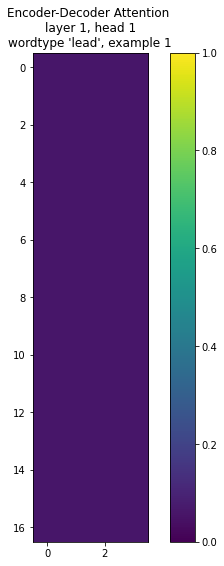

In [60]:
attn_weights = io_dict['transformer.decoder.layers.0.multihead_attn']['output'][1]
a = attn_weights[0]
a = a.transpose(0,1)
a = a.detach().numpy()

minprob, maxprob = 0.0, 1.0
example = 1
layer = 1
head = 1

plt.figure(figsize = (8,9))
plt.imshow(a, cmap='viridis', vmin=minprob, vmax=maxprob)
plt.title(f"Encoder-Decoder Attention \nlayer {layer}, head {head}\nwordtype '{w}', example {example}")
plt.colorbar()
plt.show()

## For each attention head

In [61]:
# load a model that has more than one attention head

## For each decoder layer and for multiple examples per wordtype

In [ ]:
# load a model



In [92]:
# find number of layers
num_layers = len(model.transformer.decoder.layers)

# iterate over number of layers and create hooks for each one to torchdistill
for i in range(num_layers):
    forward_hook_manager.add_hook(model, f'transformer.decoder.layers.{i}.multihead_attn', requires_input=False, requires_output=True)
    
num_layers

8

In [194]:
# execute forward of model and get io dict
w = 'lead'
num_examples = 20 # set to None to get all examples for a wordtype
out_dict = get_inputs_outputs_for_wordtype(args.data, model, w, N=num_examples) 
x, y = out_dict["x"], out_dict["y"]
io_dict = forward_hook_manager.pop_io_dict()
y.shape

(20, 4, 768)

In [192]:
io_dict[f'transformer.decoder.layers.{col}.multihead_attn']['output'][1].size()

torch.Size([25, 4, 26])

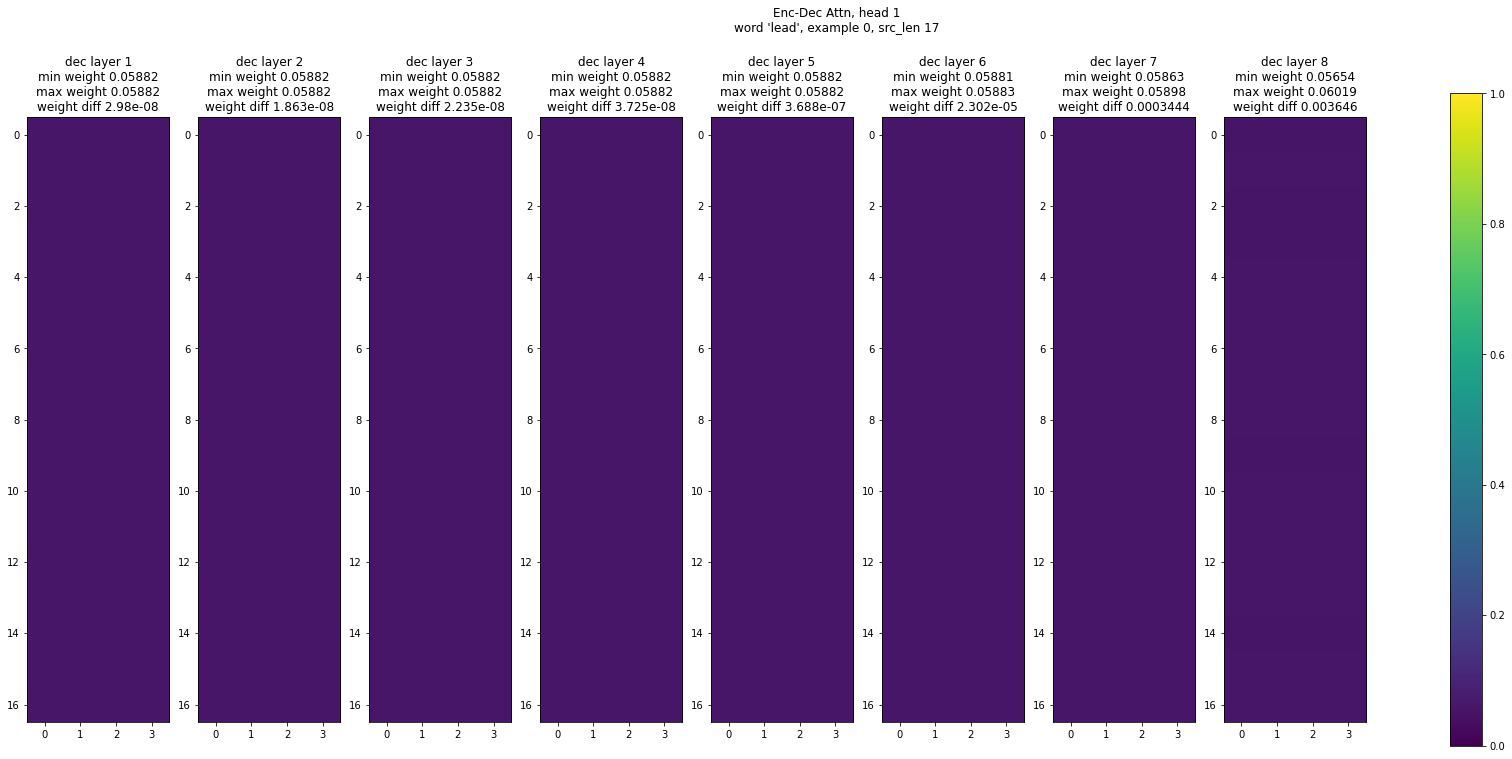

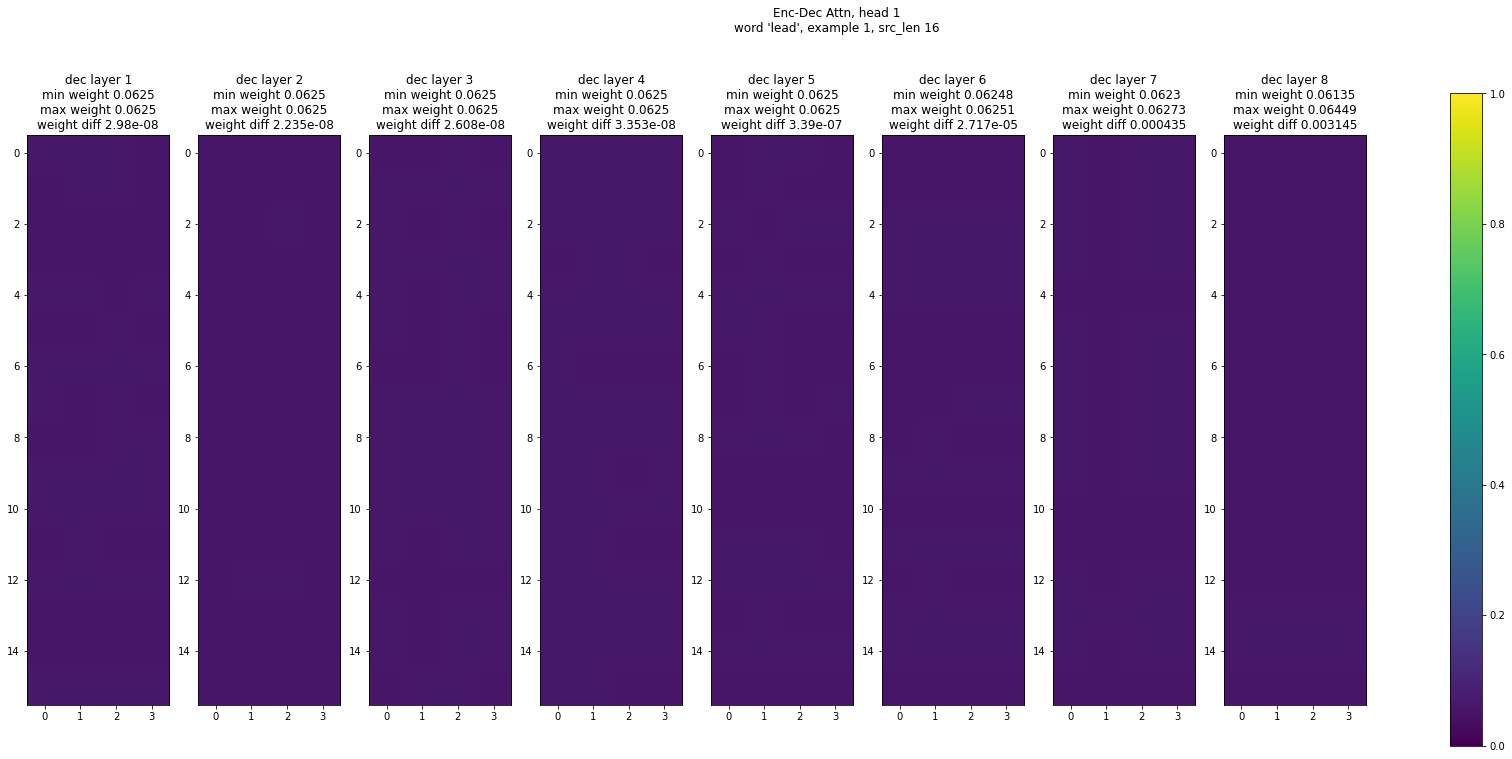

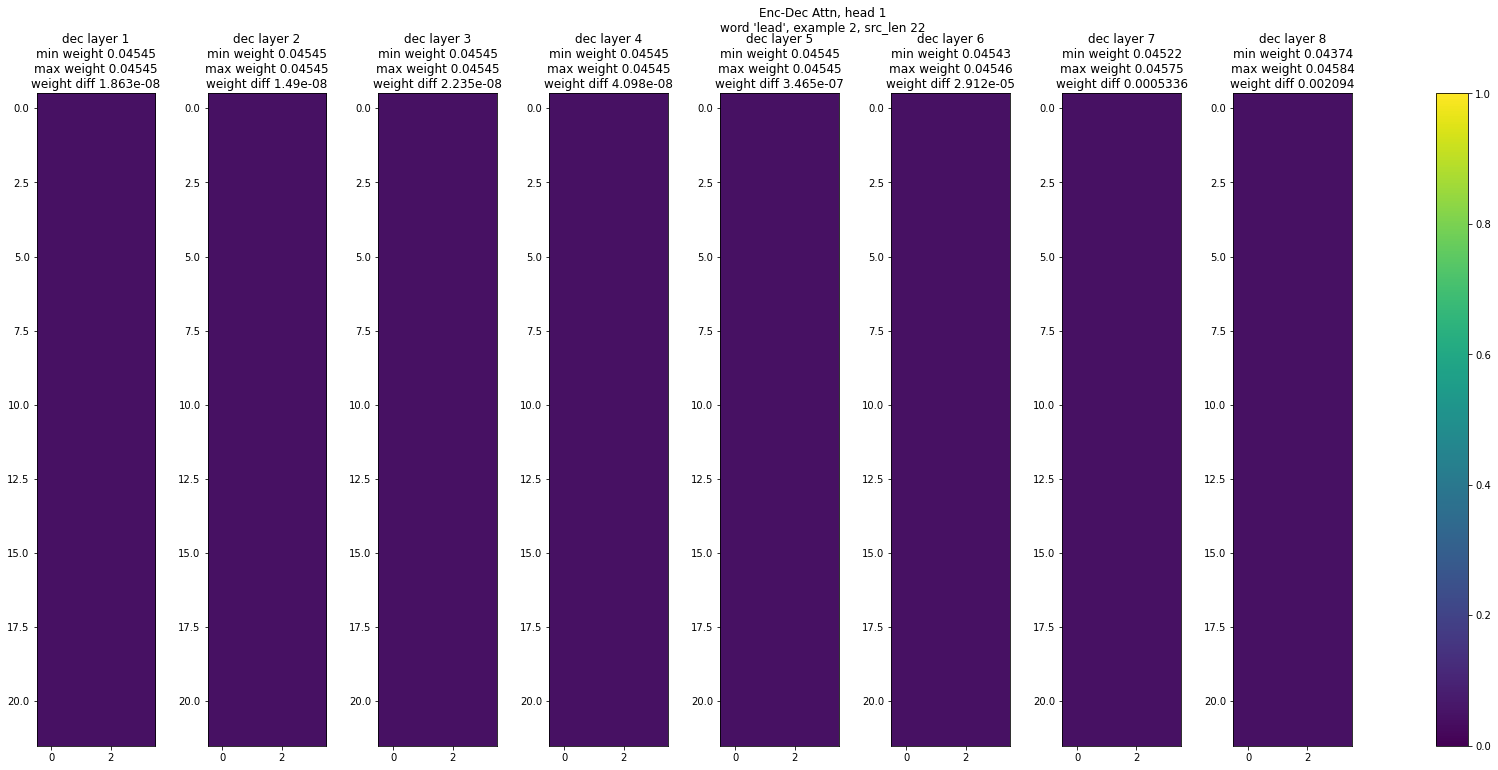

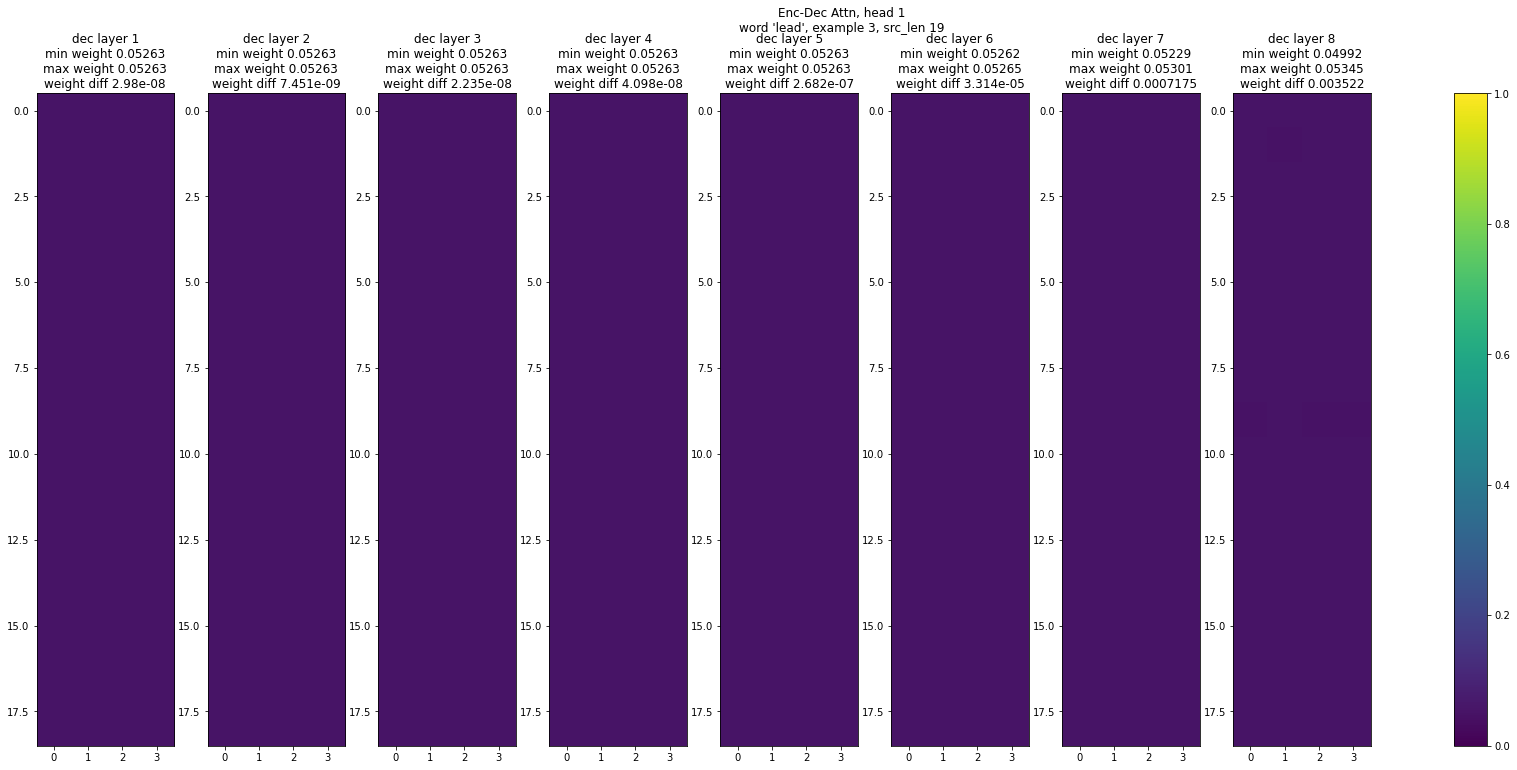

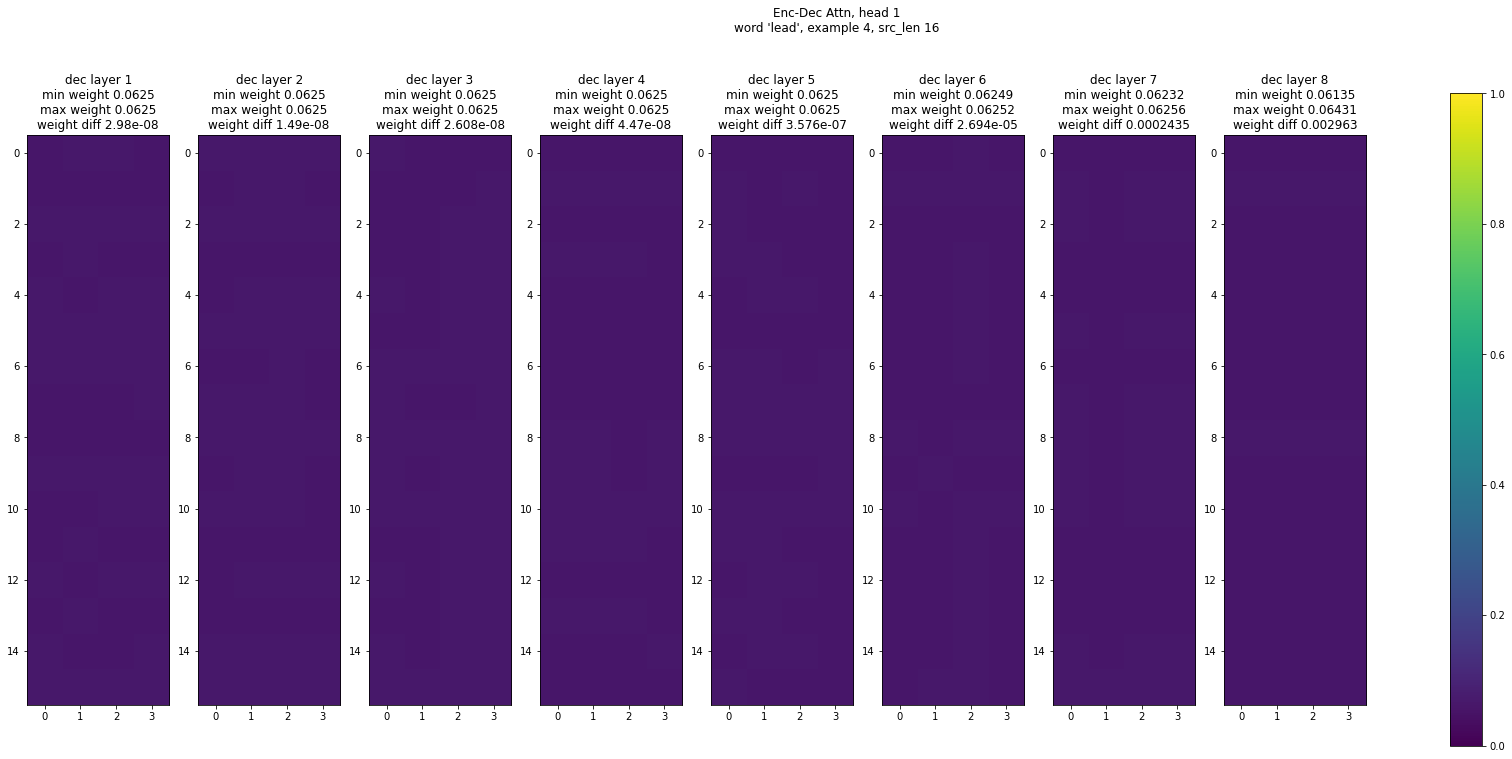

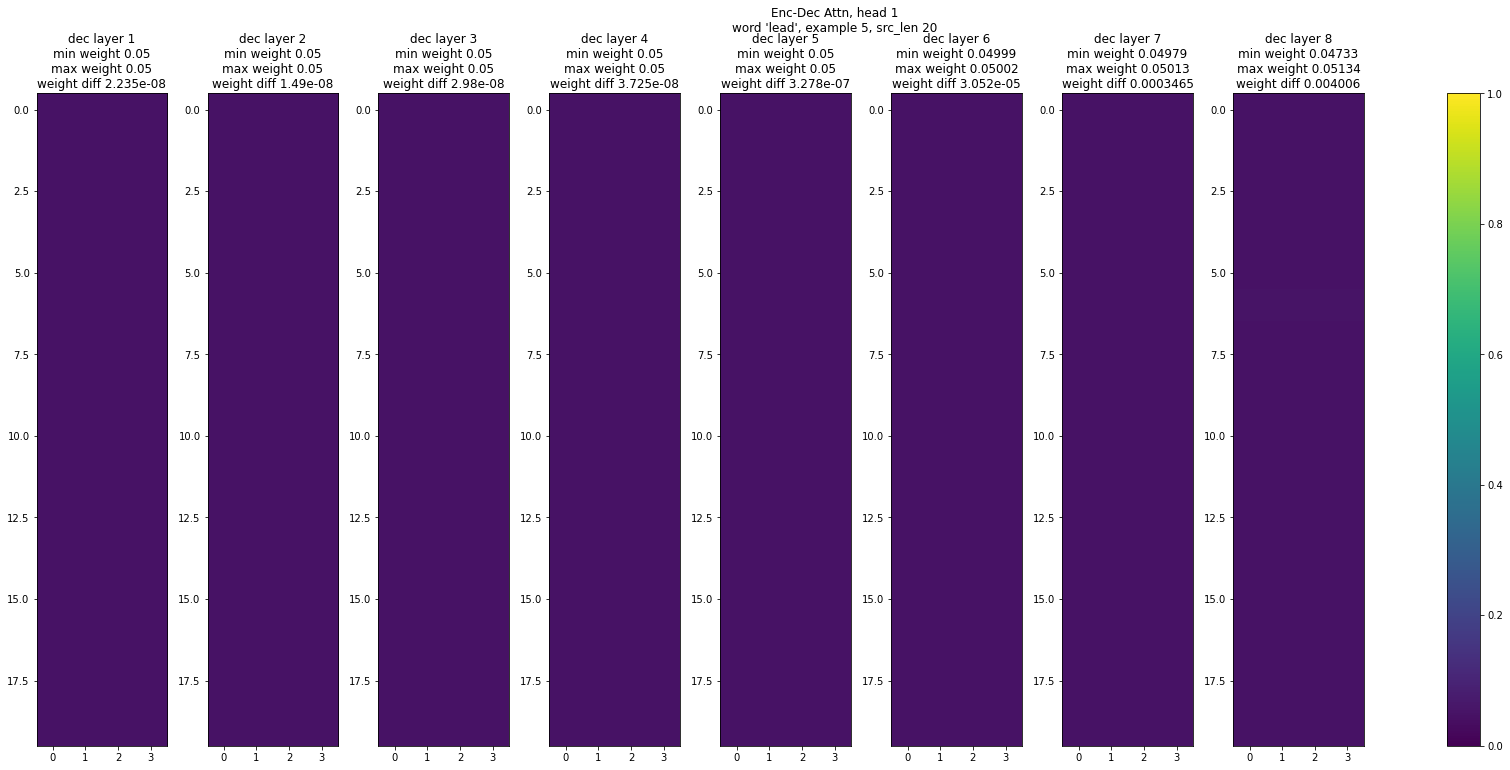

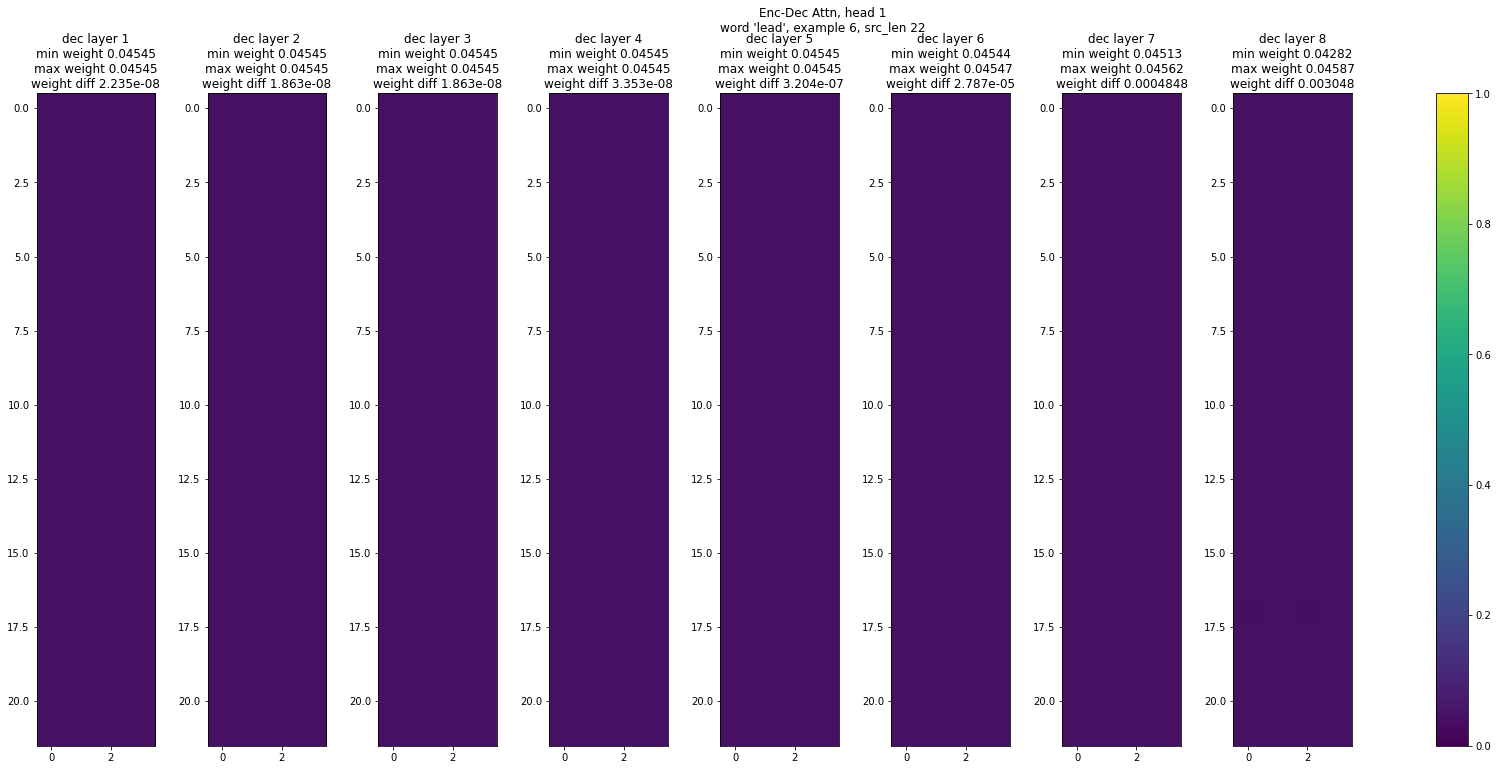

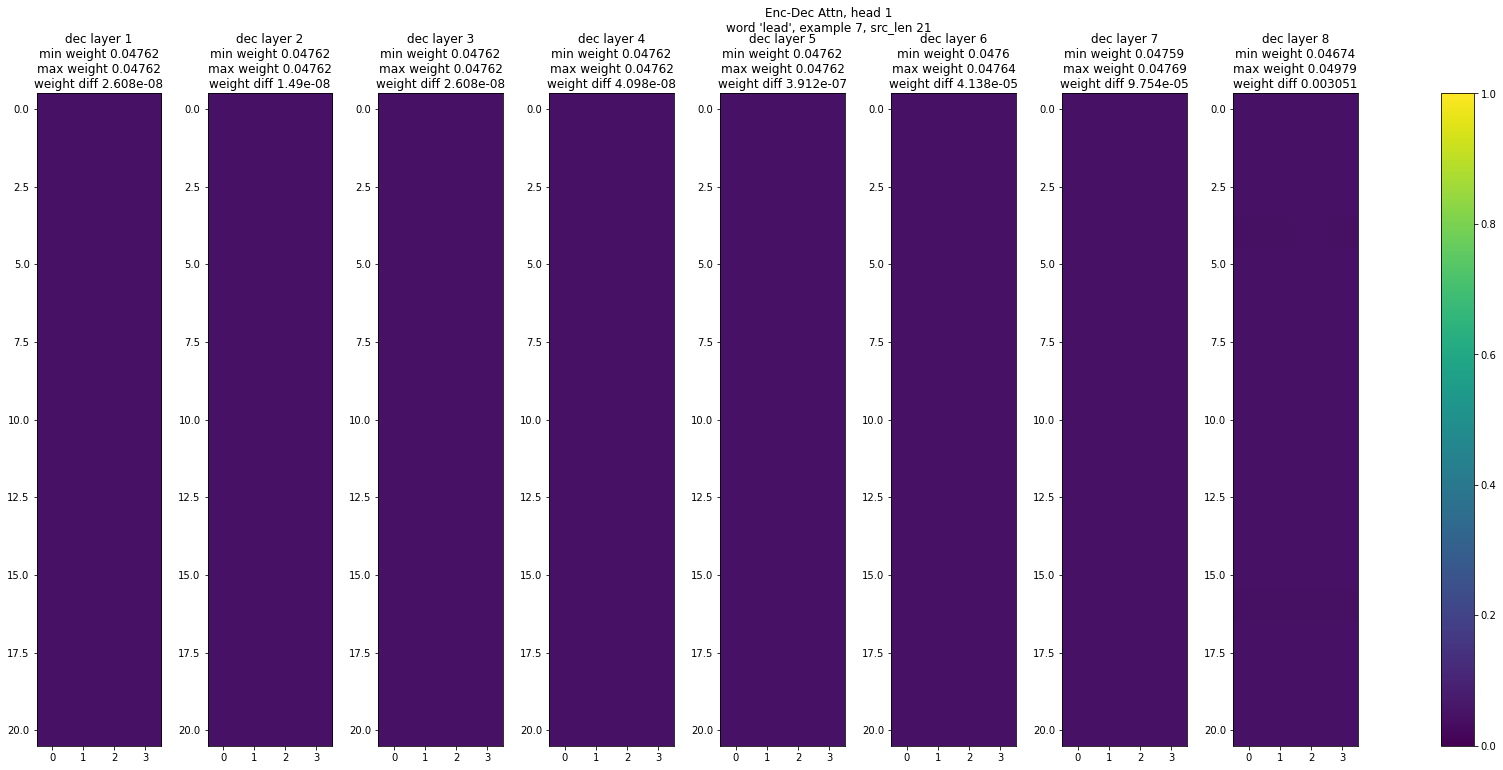

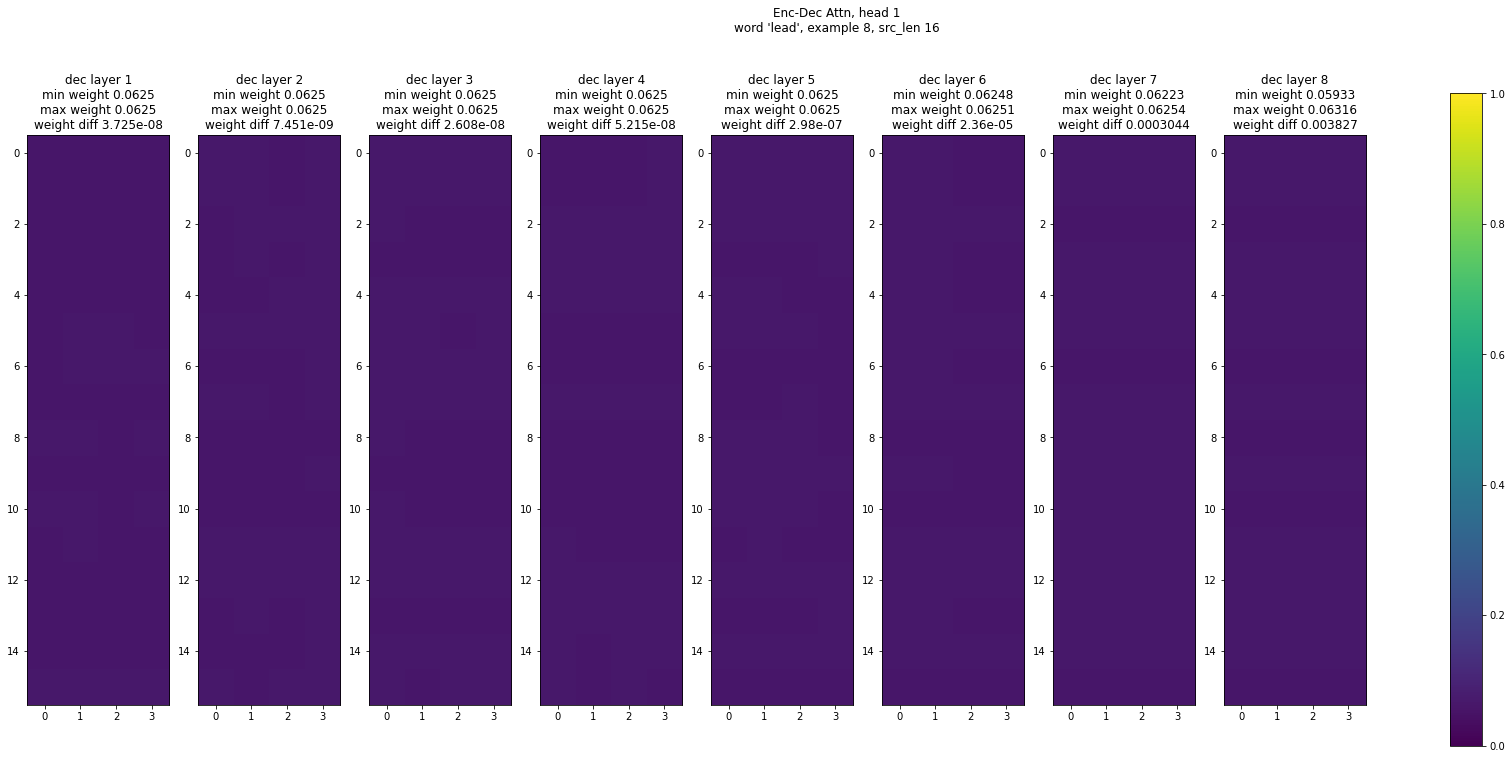

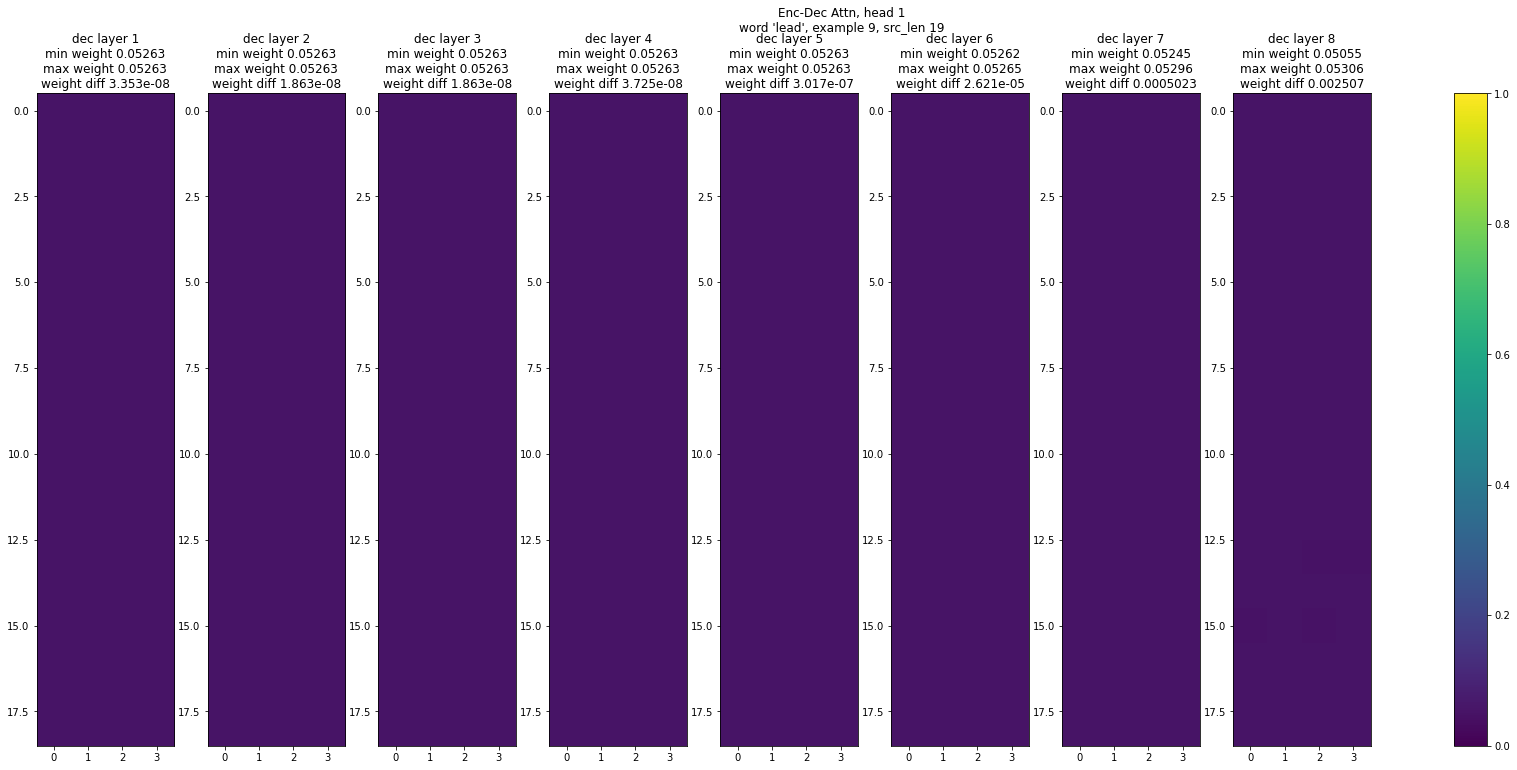

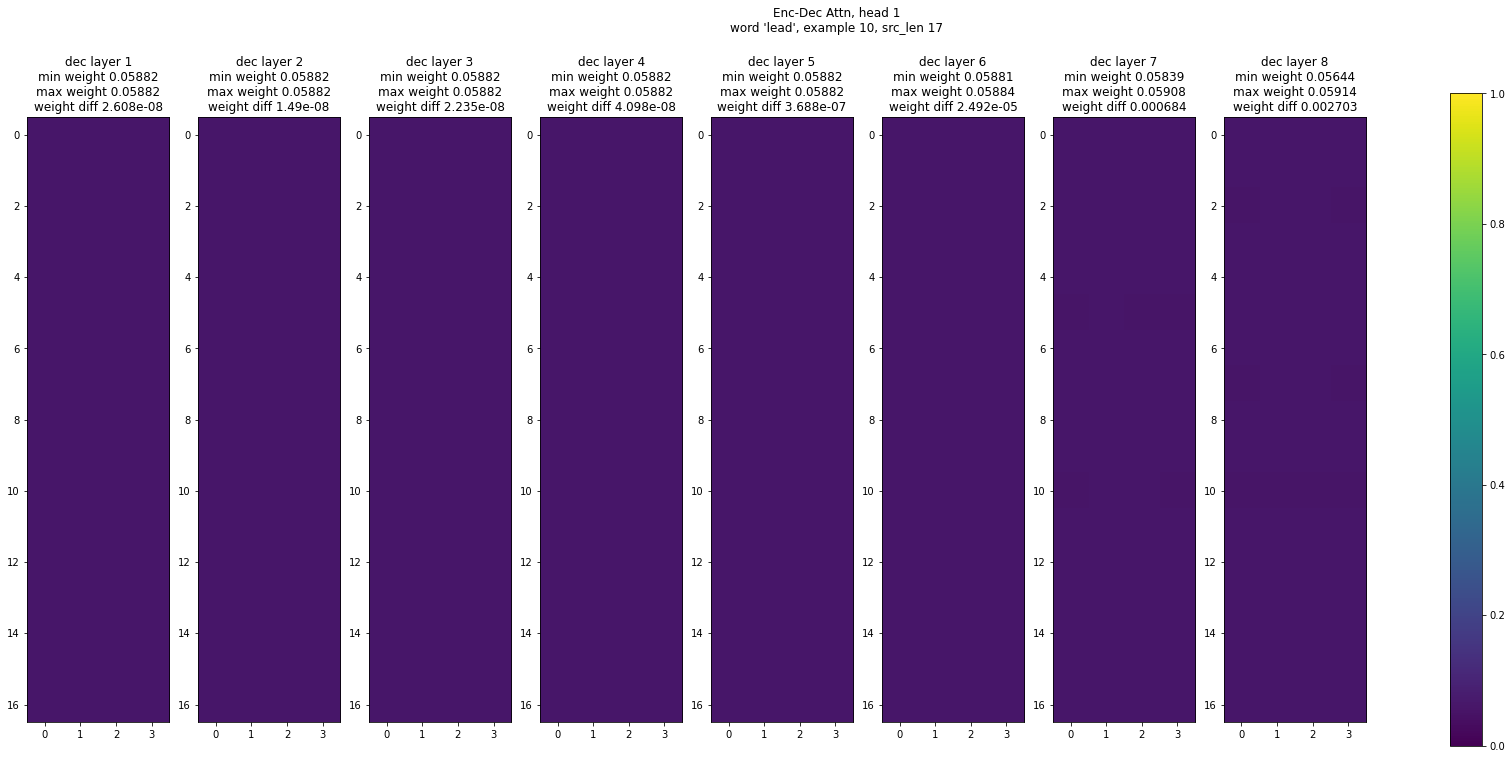

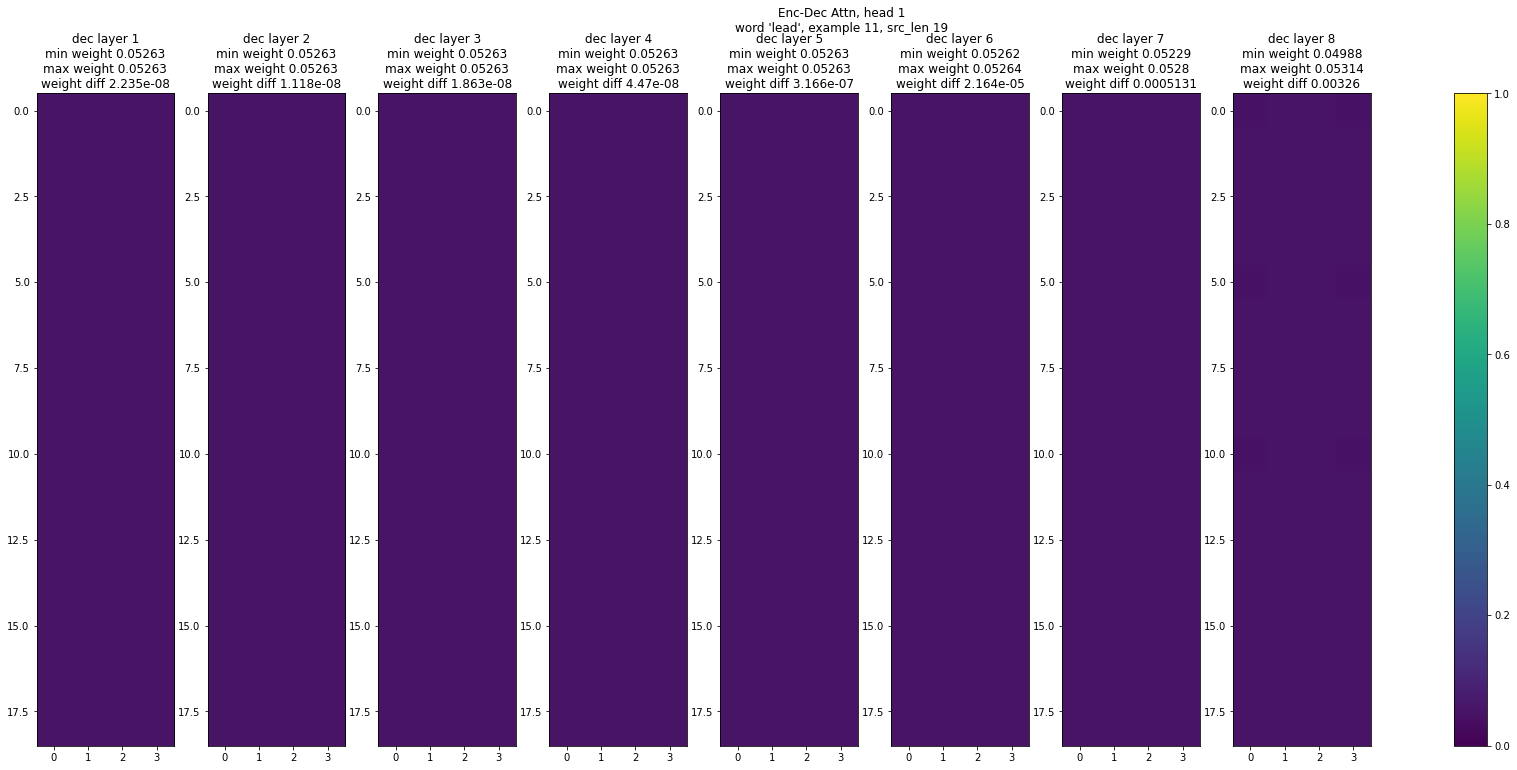

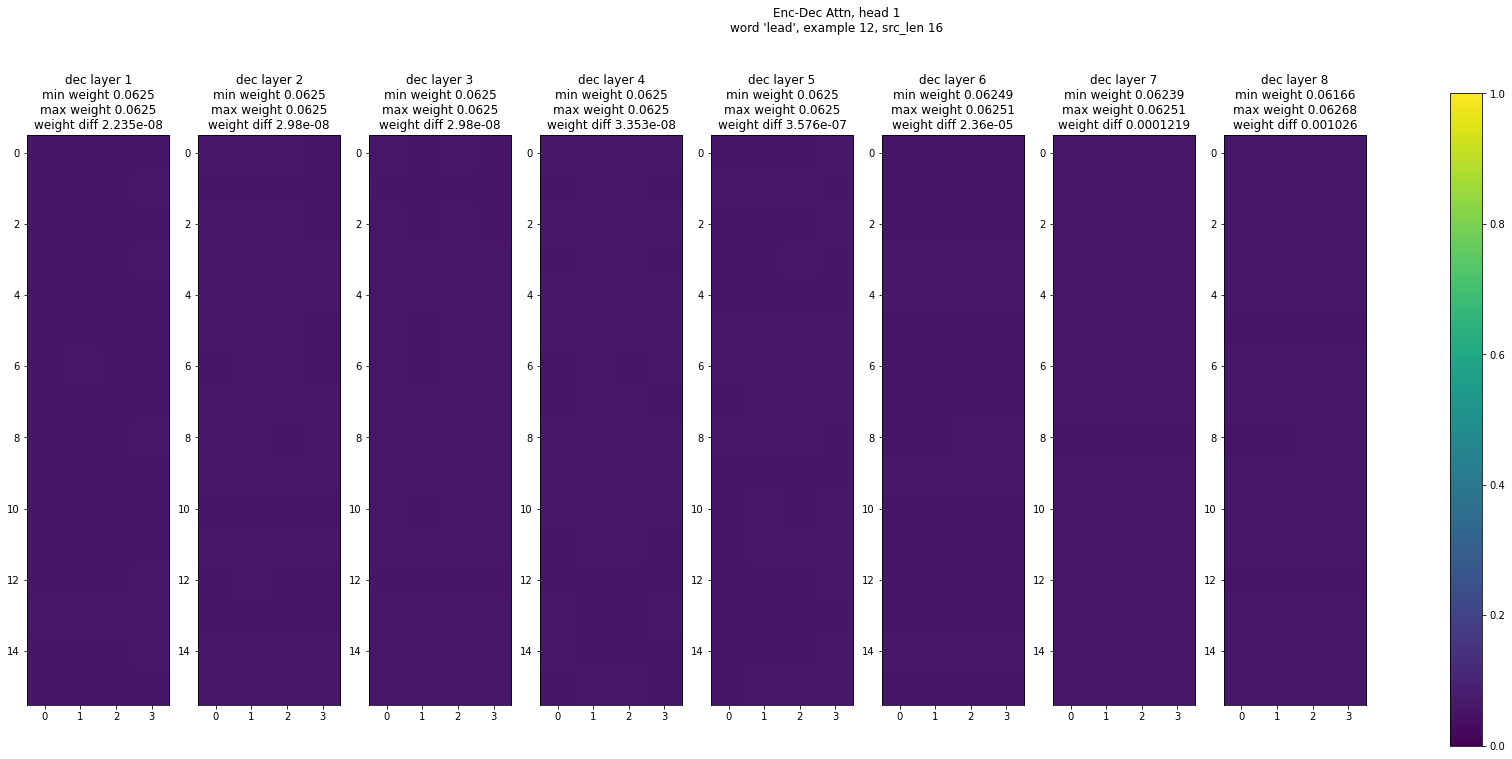

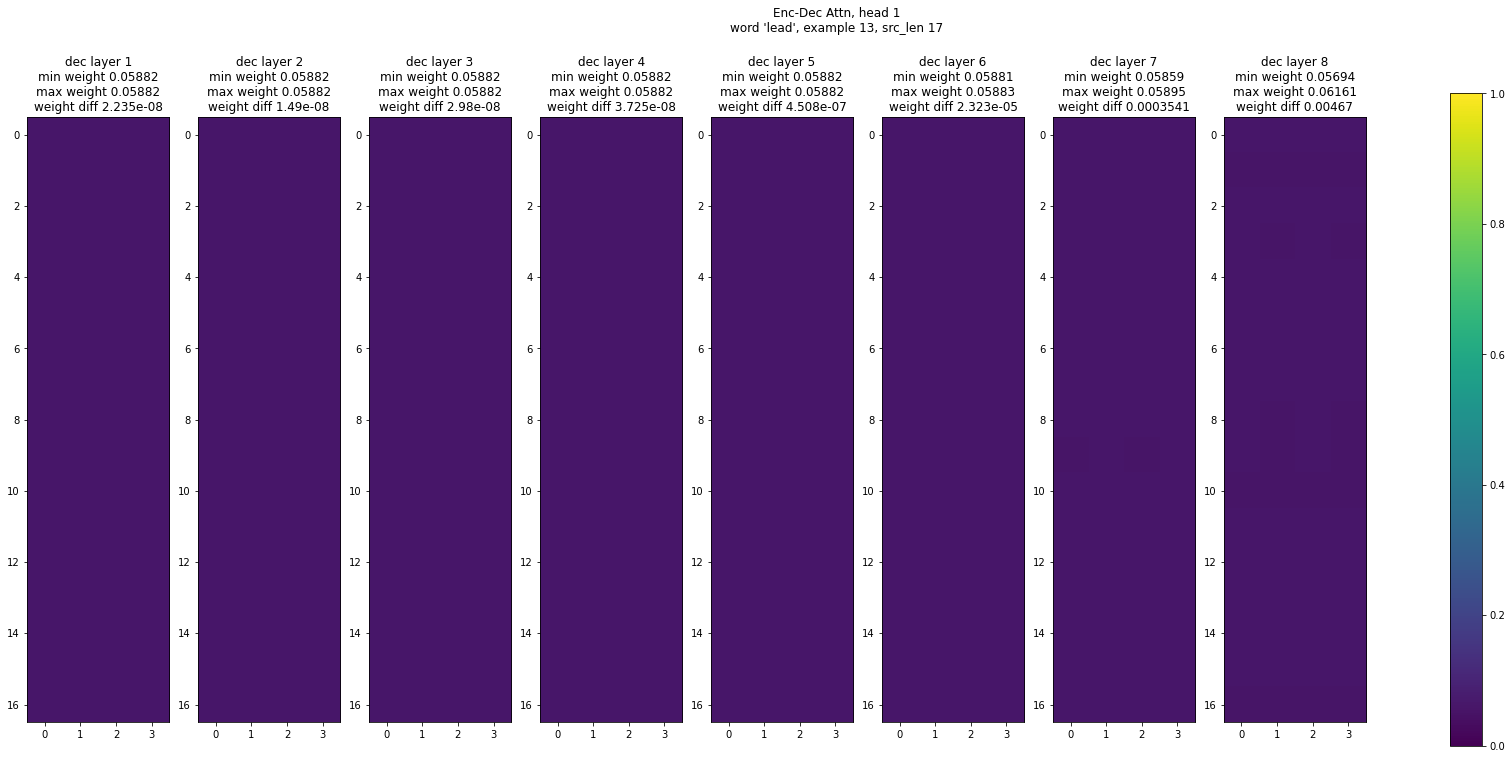

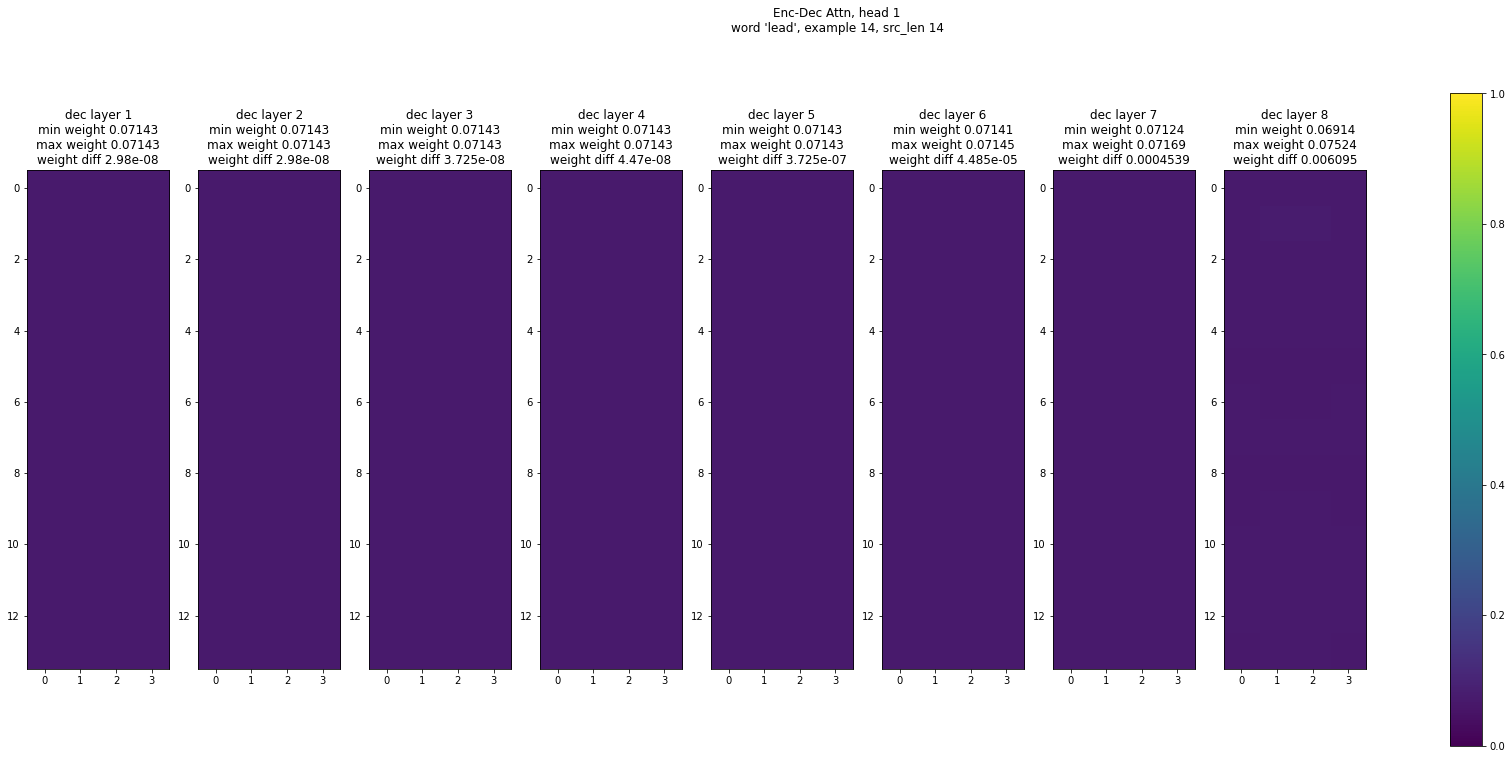

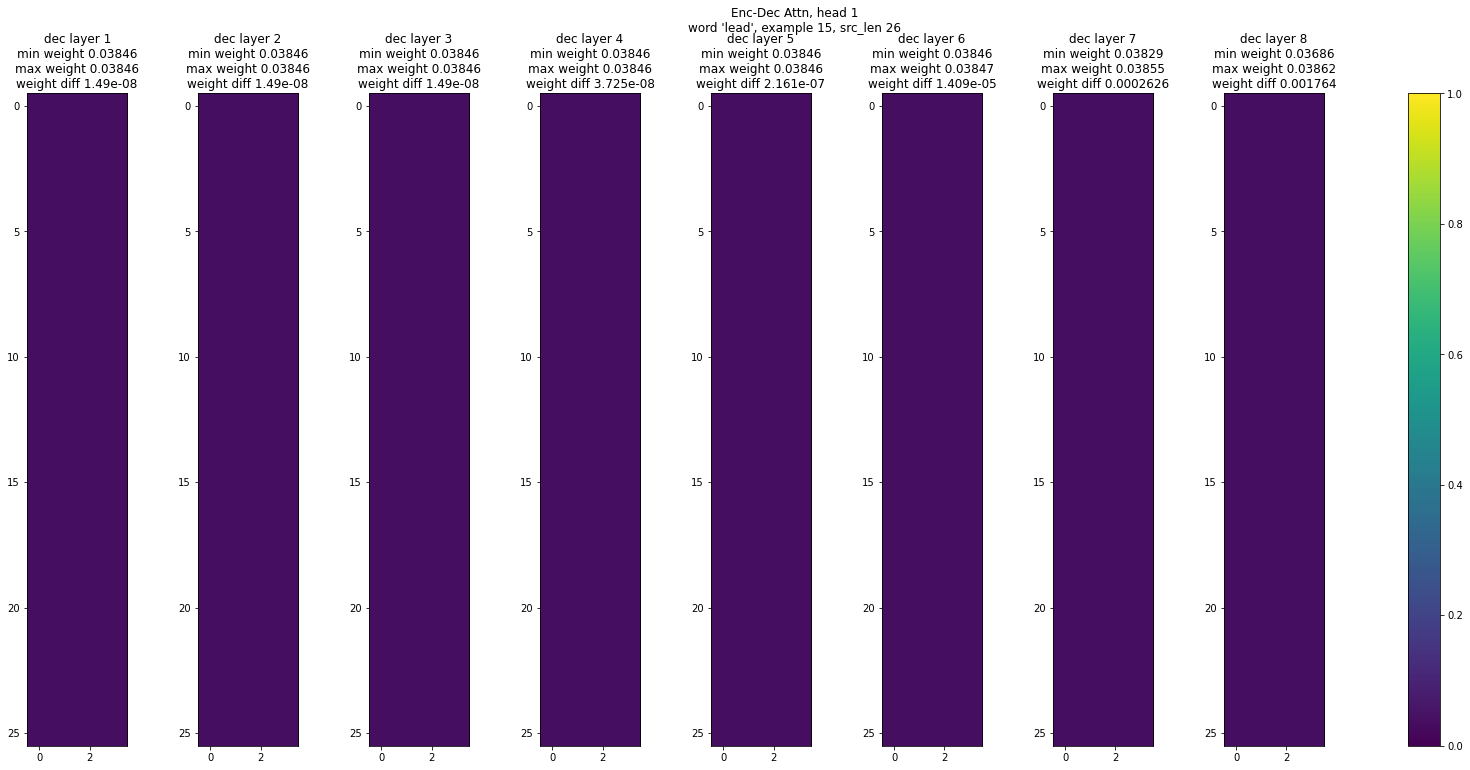

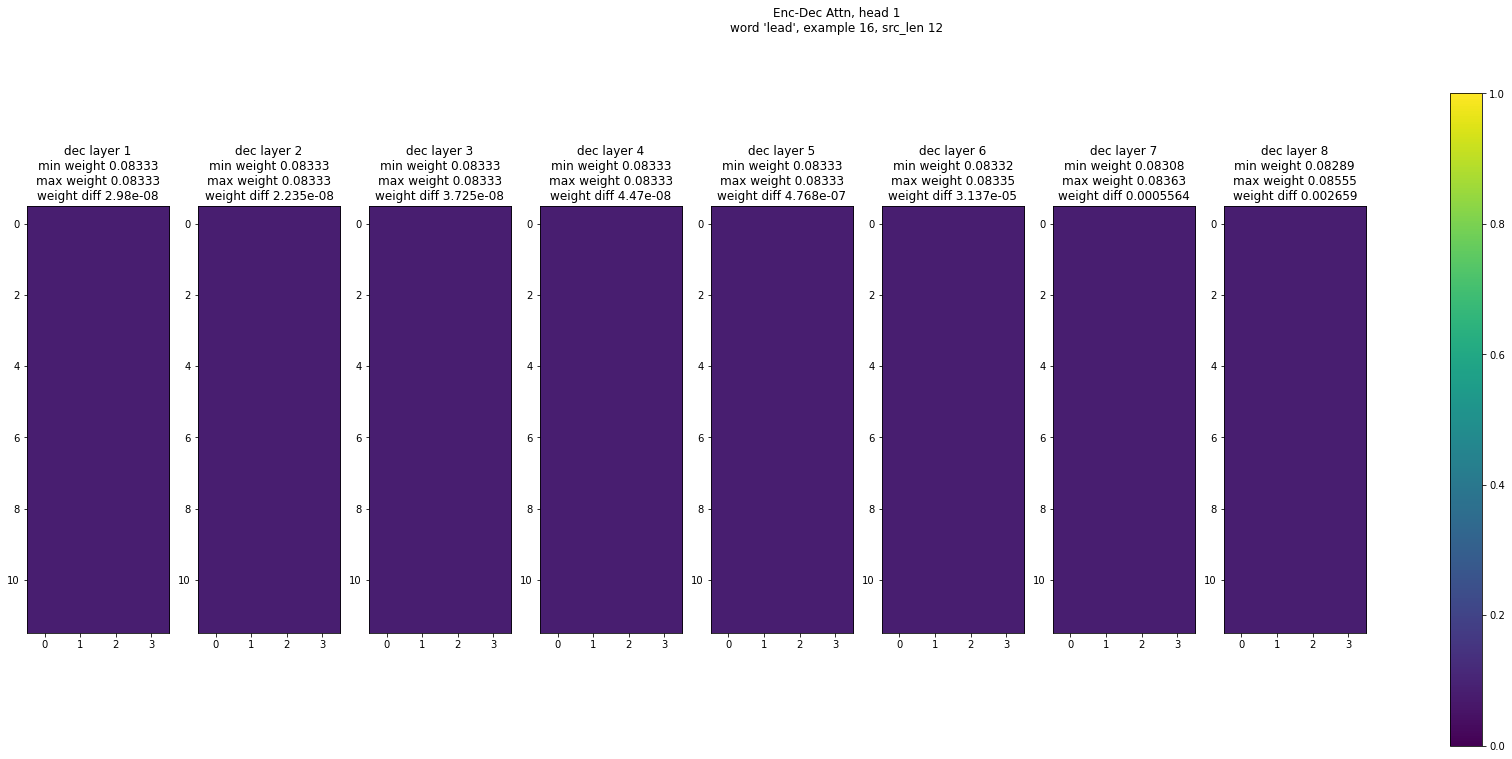

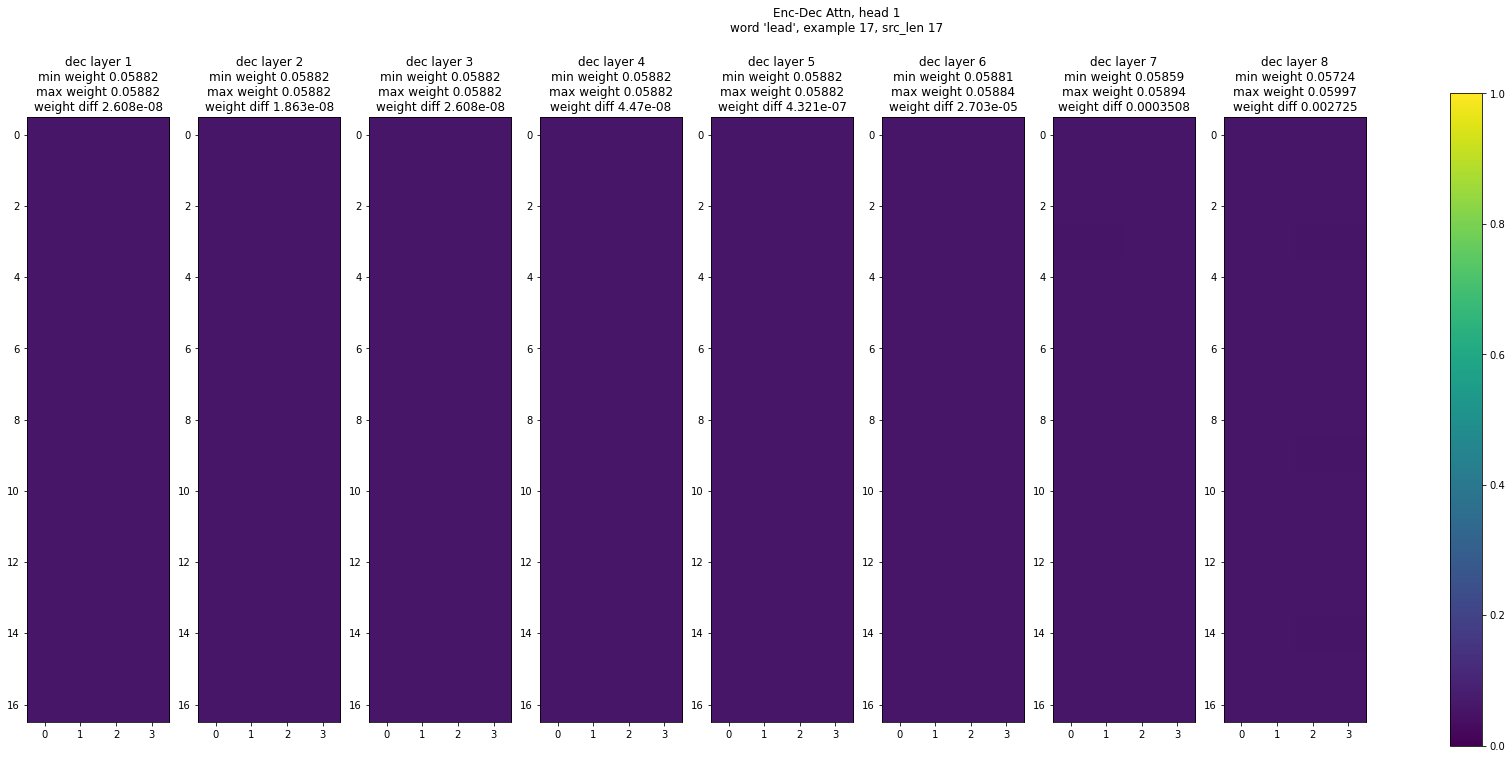

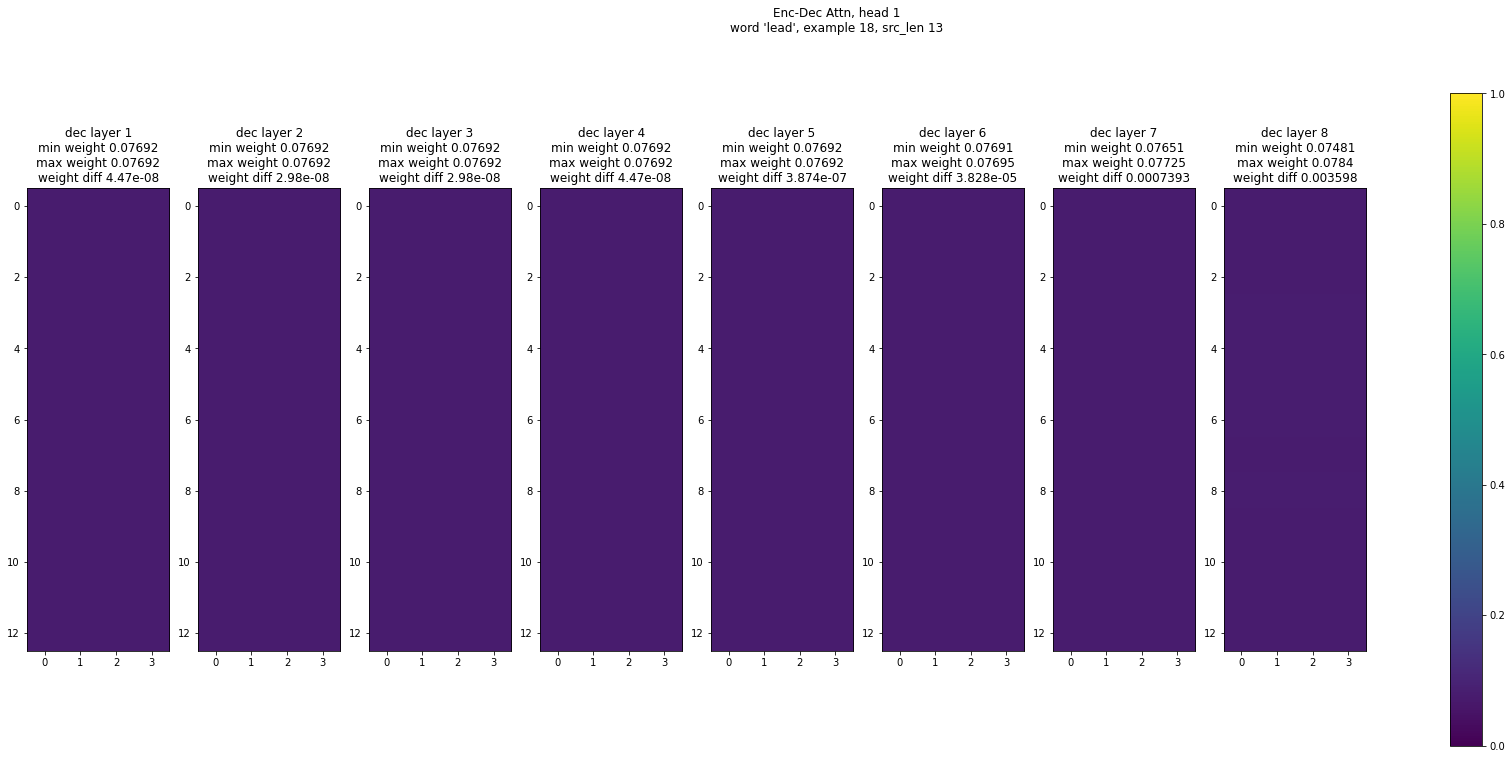

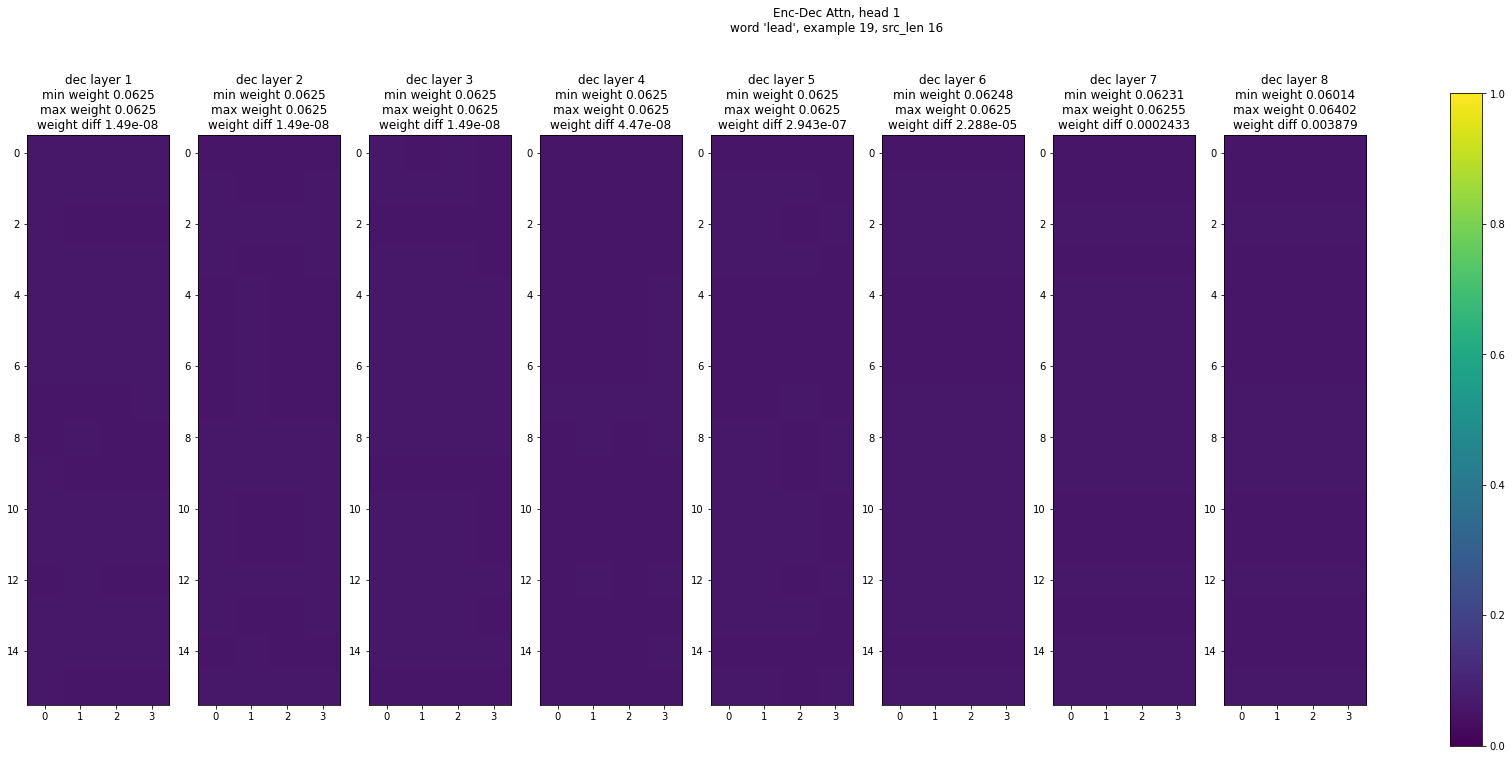

In [197]:
# fig = plt.figure(figsize = (25,18))

def plot_attentions(
    example, 
    minprob, 
    maxprob, # set min and max values for colormap. set to None to let matplotlib decide values
    src_len
):
    fig, axs = plt.subplots(1, num_layers, figsize = (30,12))
    # example = 1
    head = 1


    fig.suptitle(f"Enc-Dec Attn, head {head}\nword '{w}', example {example}, src_len {src_len}")

    # each column in subplot will be a different attention matrix
    for col in range(num_layers):
        # for row in range(num_rows): # only needed if we have multiple rows of subplots

        # get attention weights for this layer
        attn_weights = io_dict[f'transformer.decoder.layers.{col}.multihead_attn']['output'][1] # TODO understand what indexing 0 and 1 corresponds to...
        a = attn_weights[example]
        a = a.transpose(0,1)[:src_len, :]
        a = a.detach().numpy()

        # plot attention weights for this layer
        ax = axs[col]
        im = ax.imshow(a, cmap='viridis', vmin=minprob, vmax=maxprob)
        ax.set_title(f"dec layer {1+col}\nmin weight {a.min():.4g}\nmax weight {a.max():.4g}\nweight diff {a.max() - a.min():.4g}")

    fig.colorbar(im, ax=axs)
    
for example in range(y.shape[0]):
    plot_attentions(example, minprob=0.0, maxprob=1.0, src_len=int(out_dict["src_lengths"][example]))
    # plot_attentions(example, minprob=None, maxprob=None, src_len=int(out_dict["src_lengths"][example]))

# investigate embed_tgt_tokens

In [65]:
print(io_dict['embed_tgt_tokens']['output'][:,0,:]) # TODO why is each timestep different? because of positional encoding???
print(model.embed_tgt_tokens.weight[0])
print(model.embed_tgt_tokens.weight[1])

tensor([[ 8.4896e-01,  7.5487e-01,  8.4520e-01,  7.6047e-01,  7.8999e-01,
          8.3560e-01,  7.4471e-01,  7.1789e-01,  7.3329e-01,  7.4596e-01,
          6.7933e-01,  7.4629e-01,  6.8159e-01,  6.8758e-01,  6.3342e-01,
          7.0655e-01,  6.2963e-01,  6.2935e-01,  5.5669e-01,  6.1800e-01,
          5.9858e-01,  5.2769e-01,  6.1337e-01,  5.3649e-01,  4.9350e-01,
          5.2548e-01,  5.1177e-01,  5.4081e-01,  4.8859e-01,  4.5224e-01,
          5.4742e-01,  4.9029e-01,  4.7723e-01,  5.1518e-01,  4.1562e-01,
          3.9737e-01,  4.1856e-01,  4.1587e-01,  3.6206e-01,  3.8888e-01,
          3.1776e-01,  3.3625e-01,  3.5928e-01,  3.7575e-01,  2.5407e-01,
          3.3570e-01,  2.8269e-01,  3.0492e-01,  3.7922e-01,  3.6666e-01,
          2.4330e-01,  2.8921e-01,  2.7929e-01,  3.2693e-01,  3.0664e-01,
          2.8541e-01,  2.2022e-01,  2.8628e-01,  2.7002e-01,  2.0124e-01,
          2.5719e-01,  2.7961e-01,  1.9963e-01,  1.9709e-01,  2.3515e-01,
          2.0448e-01,  2.3274e-01,  1.